
## Exploration (EDA) für `spotify.sqlite`

**Ziel:** Diese Notebook führt eine EDA für den bereitgestellten Spotify-Basisdatensatz (SQLite) durch.

In [64]:

# --- Grundlegendes Setup ---
import sqlite3
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Matplotlib: keine Styles/keine festen Farben setzen
plt.rcParams.update({'figure.figsize': (8, 5), 'axes.grid': True})

RAW_SPOTIFY_DB_PATH = Path("../data/raw/spotify.sqlite")
SCHEMA_REPORTS_DIR = Path("../data/reports/01_schema_overview")
SCHEMA_REPORTS_DIR.mkdir(parents=True, exist_ok=True)


### 1.1 Datenbankstruktur und Tabellenübersicht

Bevor ich mit der eigentlichen Analyse beginne, will ich ein klares Verständnis der Struktur des Spotify-Datenbestands gewinnen.
Dazu prüfe ich:
- Welche Tabellen existieren in der SQLite-Datenbank
- Wie viele Zeilen jede Tabelle enthält
- Welche Spalten und Datentypen sie besitzen
- Welche Felder Primärschlüssel sind


In [65]:
# Verbindung nur für Schema-Abfrage (UTF-8/Bytes egal, da keine Daten gelesen werden)
pd.set_option('display.max_colwidth', None)

con_overview = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))

# Gibt alle Benutzertabellen (ohne SQLite-Systemtabellen) zurück
def list_user_tables(con):
    q = """
    SELECT name
    FROM sqlite_master
    WHERE type='table' AND name NOT LIKE 'sqlite_%'
    ORDER BY name;
    """
    return pd.read_sql(q, con)['name'].tolist()

# Liest Spalteninformationen einer Tabelle (Name, Typ, Primärschlüssel usw.)
def get_table_info(con, table):
    info = pd.read_sql(f"PRAGMA table_info({table});", con)
    return info

# Gibt die Anzahl der Zeilen einer Tabelle zurück
def get_rowcount(con, table):
    try:
        return pd.read_sql(f"SELECT COUNT(*) AS n FROM {table};", con).iloc[0, 0]
    except Exception:
        return None

# Baut eine Gesamtübersicht: Tabellenname, Zeilenanzahl, Spaltenanzahl, Spaltenliste
def build_db_summary(con, max_preview_chars: int = 140):
    tables = list_user_tables(con)
    rows = []
    column_details = {}

    for t in tables:
        info = get_table_info(con, t)
        column_details[t] = info

        # Spaltenliste mit Typ und PK-Markierung
        col_display = [
            f"{r['name']} ({r['type']})" + (" [PK]" if r['pk'] == 1 else "")
            for _, r in info.iterrows()
        ]
        rowcount = get_rowcount(con, t)

        rows.append({
            "table": t,
            "rowcount": rowcount,
            "n_columns": len(col_display),
            "columns_full": ", ".join(col_display)
        })

    summary = pd.DataFrame(rows).sort_values("rowcount", ascending=False)
    # Kürze Spaltenliste für Übersicht (volle Liste bleibt in columns_full)
    summary["columns_preview"] = summary["columns_full"].apply(
        lambda s: s if len(s) <= max_preview_chars else s[:max_preview_chars] + "…"
    )
    summary = summary[["table", "rowcount", "n_columns", "columns_preview", "columns_full"]]
    return summary, column_details

#  Erstelle die Übersicht und zeige sie an
db_summary, db_column_details = build_db_summary(con_overview)

print("Tabellen-Übersicht:")
display(db_summary[["table", "rowcount", "n_columns", "columns_preview"]])

#  Speichere die vollständige Übersicht als CSV
out_dir = Path(SCHEMA_REPORTS_DIR)
out_dir.mkdir(parents=True, exist_ok=True)
db_summary.to_csv(out_dir / "schema_overview.csv", index=False, encoding="utf-8")
print(f" Gespeichert: {out_dir / 'schema_overview.csv'}")

#  Verbindung schließen
con_overview.close()



Tabellen-Übersicht:


table  rowcount  n_columns  \
7    r_track_artist  11840402          2   
5   r_albums_tracks   9900173          2   
8            tracks   8741672         10   
2    audio_features   8740043         15   
0            albums   4820754          6   
1           artists   1066031          4   
4  r_albums_artists    921486          2   
6    r_artist_genre    487386          2   
3            genres      5489          1   

                                                                                                                                 columns_preview  
7                                                                                                                      track_id (), artist_id ()  
5                                                                                                                       album_id (), track_id ()  
8  id (), disc_number (), duration (), explicit (), audio_feature_id (), name (), preview_url (), track_number (), popularity (), is_playable (…  
2  id (), acousticness (), analysis_url (), danceability (), duration (), energy (), instrumentalness (), key (), liveness (), loudness (), mod…  
0                                                                  id (), name (), album_group (), album_type (), release_date (), popularity ()  
1                                                                                                    name (), id (), popularity (), followers ()  
4                                                                                                                      album_id (), artist_id ()  
6                                                                                                                      genre_id (), artist_id ()  
3                                                                                                                                          id ()

 Gespeichert: ..\data\reports\01_schema_overview\schema_overview.csv


###  1.2 Überblick über Tabelleninhalte

#### Ziel

Nachdem wir das Schema und die Zeilenzahlen kennen, wollen wir uns nun die Inhalte der wichtigsten Tabellen ansehen.
Wir prüfen einige Beispieleinträge und Datentypen, um zu verstehen, welche Informationen für Analysen relevant sind.

#### Vorgehen

Wir laden jeweils die erste Zeile der Tabellen nur zur Überblick.

In [66]:
key_tables = ['artists', 'tracks', 'audio_features', 'albums', 'genres']
con = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))
for t in key_tables:
    print(f"\n{'='*70}\n Tabelle: {t.upper()}\n{'='*70}")
    try:
        df = pd.read_sql(f"SELECT * FROM {t} LIMIT 5;", con)
        display(df.head(1))  # Beispielzeile
        print("\n Spaltentypen:")
        display(df.dtypes.to_frame(name="dtype"))
    except Exception as e:
        print(f" Fehler beim Lesen von {t}: {e}")


 Tabelle: ARTISTS


name                      id  popularity  followers
0  Xzibit  4tujQJicOnuZRLiBFdp3Ou          69    1193665


 Spaltentypen:


dtype
name        object
id          object
popularity   int64
followers    int64


 Tabelle: TRACKS


id  disc_number  duration  explicit  \
0  1dizvxctg9dHEyaYTFufVi            1    275893         1   

         audio_feature_id                                   name preview_url  \
0  1dizvxctg9dHEyaYTFufVi  Gz And Hustlas (feat. Nancy Fletcher)               

   track_number  popularity  is_playable  
0            12           0          NaN


 Spaltentypen:


dtype
id                 object
disc_number         int64
duration            int64
explicit            int64
audio_feature_id   object
name               object
preview_url        object
track_number        int64
popularity          int64
is_playable       float64


 Tabelle: AUDIO_FEATURES


id  acousticness  \
0  2jKoVlU7VAmExKJ1Jh3w9P          0.18   

                                                       analysis_url  \
0  https://api.spotify.com/v1/audio-analysis/2jKoVlU7VAmExKJ1Jh3w9P   

   danceability  duration  energy  instrumentalness  key  liveness  loudness  \
0         0.893    219160   0.514               0.0   11    0.0596     -5.08   

   mode  speechiness   tempo  time_signature  valence  
0     1        0.283  95.848               4    0.787


 Spaltentypen:


dtype
id                 object
acousticness      float64
analysis_url       object
danceability      float64
duration            int64
energy            float64
instrumentalness  float64
key                 int64
liveness          float64
loudness          float64
mode                int64
speechiness       float64
tempo             float64
time_signature      int64
valence           float64


 Tabelle: ALBUMS


id                                        name  \
0  2jKoVlU7VAmExKJ1Jh3w9P  Alkaholik (feat. Erik Sermon, J Ro & Tash)   

  album_group album_type  release_date  popularity  
0                  album  954633600000           0


 Spaltentypen:


dtype
id            object
name          object
album_group   object
album_type    object
release_date   int64
popularity     int64


 Tabelle: GENRES


id
0  detroit hip hop


 Spaltentypen:


dtype
id  object

### 1.3 Tabellen als CSV-Dateien speichern

**Ziel**
Ich exportiere die wichtigsten Tabellen aus der SQLite-Datenbank als handliche CSV-Dateien nach `../data/converted/`.
So kann ich später schneller mit Pandas arbeiten, ohne die komplette DB jedes Mal neu zu laden.

**Vorgehen**
- Ich wähle die Kern-Tabellen (`tracks`, `audio_features`, `artists`, `albums`, Relationen) und nur relevante Spalten aus.
- Um Speicher und Zeit zu sparen, ziehe ich pro Tabelle eine reproduzierbare Stichprobe.

**Ergebnis**
- CSV-Dateien für Analysen liegen unter `../data/converted/`.


In [67]:
# ================================================================
# ------------------------------------------------
# Zweck:
#   Exportiere eine verbundene, ML-freundliche Stichprobe (<= 300k Tracks) aus einer großen
#   Spotify-ähnlichen SQLite-DB, ohne komplette Tabellen in pandas zu laden.
#
# Warum diese Strategie für deine ML-Aufgaben am besten ist:
#   - Regressionsmodellierung der Track-Popularität benötigt das vollständige Popularitätsspektrum
#   - Hit-Vorhersage benötigt ausreichend viele hoch-populäre Tracks (seltene Klasse)
#   - Explicit-/Inhaltsvorhersage benötigt Coverage von Audio-Features (audio_feature_id nicht null)
#   - Künstler-Cluster profitieren von breiter Künstlerabdeckung
#
# Ausgabe:
#   ../data/interim/converted_sqlite/*.csv
#   (tracks, albums, artists, audio_features, genres, Verknüpfungstabellen)
#
# Hinweise:
#   - Kein globales ORDER BY random()
#   - Verwendet HYBRID_STRATIFIED Sampling (empfohlen) + FAST_APPROX Füllung falls nötig
#   - Extrahiert einen verbundenen Subgraphen über Joins auf temporären Tabellen
# ================================================================

import sqlite3
import pandas as pd
from pathlib import Path
import json
import time


# ----------------------------------------------------------------
# Paths & Parameters
# ----------------------------------------------------------------
EXPORT_DIR = Path("../data/interim/converted_sqlite")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# Target sample size
TARGET_TRACKS = 300_000
SAMPLING_MODE = "HYBRID_STRATIFIED"
APPROX_MOD = 200
APPROX_THRESH = 5

# Repro/quality knobs
REQUIRE_AUDIO_FEATURES = True          # keep tracks with audio_feature_id
MIN_EXPLICIT_SHARE = 0.25              # guarantee >=25% explicit tracks in sample
HIT_MIN_POP = 70                       # "hit-like" threshold for hit training enrichment
HIT_SHARE_IN_SAMPLE = 0.20             # guarantee >=20% hit-like tracks in sample

ROW_MOD = 200

# ----------------------------------------------------------------
# Connect + PRAGMAs (performance)
# ----------------------------------------------------------------
con = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))
# Safe decode for weird bytes in string columns
con.text_factory = lambda b: b.decode("utf-8", "replace")

con.execute("PRAGMA journal_mode=OFF;")
con.execute("PRAGMA synchronous=OFF;")
con.execute("PRAGMA temp_store=MEMORY;")
con.execute("PRAGMA cache_size=-200000;")
con.execute("PRAGMA mmap_size=30000000000;")  # 30GB mmap if OS allows, otherwise ignored

cur = con.cursor()


# ----------------------------------------------------------------
# Cleanup previous TEMP tables (safe reruns)
# ----------------------------------------------------------------
cur.executescript("""
DROP TABLE IF EXISTS temp.sel_tracks;
DROP TABLE IF EXISTS temp.sel_r_albums_tracks;
DROP TABLE IF EXISTS temp.sel_r_track_artist;
DROP TABLE IF EXISTS temp.sel_albums;
DROP TABLE IF EXISTS temp.sel_artists;
DROP TABLE IF EXISTS temp.sel_audio_features;
DROP TABLE IF EXISTS temp.sel_r_artist_genre;
DROP TABLE IF EXISTS temp.sel_genres;
DROP TABLE IF EXISTS temp.sel_r_albums_artists;
""")


# ----------------------------------------------------------------
# 1) Track selection
# ----------------------------------------------------------------

audio_filter = "AND audio_feature_id IS NOT NULL" if REQUIRE_AUDIO_FEATURES else ""

if SAMPLING_MODE == "HYBRID_STRATIFIED":

    # Compute quotas
    n_explicit = int(TARGET_TRACKS * MIN_EXPLICIT_SHARE)
    n_hit = int(TARGET_TRACKS * HIT_SHARE_IN_SAMPLE)

    remainder = TARGET_TRACKS - n_explicit - n_hit
    remainder = max(remainder, 0)

    # Split remainder into 4 popularity buckets (non-explicit preferred)
    n_b1 = remainder // 4
    n_b2 = remainder // 4
    n_b3 = remainder // 4
    n_b4 = remainder - (n_b1 + n_b2 + n_b3)

    # Create table with PK so we can INSERT OR IGNORE and avoid duplicates across slices
    cur.executescript("""
    CREATE TEMP TABLE sel_tracks (
        track_id TEXT PRIMARY KEY,
        disc_number INTEGER,
        duration INTEGER,
        explicit INTEGER,
        audio_feature_id TEXT,
        name TEXT,
        preview_url TEXT,
        track_number INTEGER,
        popularity INTEGER,
        is_playable INTEGER
    );
    """)

    # Helpful index for later joins
    cur.executescript("""
    CREATE INDEX IF NOT EXISTS idx_sel_tracks_id ON sel_tracks(track_id);
    CREATE INDEX IF NOT EXISTS idx_sel_tracks_af ON sel_tracks(audio_feature_id);
    """)

    # (A) Explicit slice (for content prediction)
    # We also require duration > 0 and popularity not null to avoid unusable rows.
    cur.execute(f"""
        INSERT OR IGNORE INTO sel_tracks
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE explicit = 1
          AND popularity IS NOT NULL
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
        LIMIT {n_explicit};
    """)

    # (B) High-popularity slice (for hit prediction + top end regression learning)
    cur.execute(f"""
        INSERT OR IGNORE INTO sel_tracks
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE popularity >= {HIT_MIN_POP}
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
        LIMIT {n_hit};
    """)

    # (C) Balanced buckets for rest (prefer non-explicit so explicit ratio stays controlled)
    # Buckets: [0-20], [21-40], [41-60], [61-(HIT_MIN_POP-1)]
    cur.execute(f"""
        INSERT OR IGNORE INTO sel_tracks
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE explicit = 0
          AND popularity BETWEEN 0 AND 20
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
        LIMIT {n_b1};
    """)
    cur.execute(f"""
        INSERT OR IGNORE INTO sel_tracks
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE explicit = 0
          AND popularity BETWEEN 21 AND 40
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
        LIMIT {n_b2};
    """)
    cur.execute(f"""
        INSERT OR IGNORE INTO sel_tracks
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE explicit = 0
          AND popularity BETWEEN 41 AND 60
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
        LIMIT {n_b3};
    """)
    cur.execute(f"""
        INSERT OR IGNORE INTO sel_tracks
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE explicit = 0
          AND popularity BETWEEN 61 AND {HIT_MIN_POP - 1}
          {audio_filter}
          AND duration IS NOT NULL AND duration > 0
        LIMIT {n_b4};
    """)

    # (D) Filler if we still didn't reach the target
    # This happens because PK dedupe removes overlaps between slices.
    n_now = cur.execute("SELECT COUNT(*) FROM sel_tracks;").fetchone()[0]
    missing = TARGET_TRACKS - n_now

    if missing > 0:
        cur.execute(f"""
            INSERT OR IGNORE INTO sel_tracks
            SELECT id AS track_id,
                   disc_number, duration, explicit, audio_feature_id,
                   name, preview_url, track_number, popularity, is_playable
            FROM tracks
            WHERE (abs(random()) % {APPROX_MOD}) < {APPROX_THRESH}
              {audio_filter}
              AND duration IS NOT NULL AND duration > 0
              AND popularity IS NOT NULL
            LIMIT {missing};
        """)

elif SAMPLING_MODE == "ROWID_MOD":
    cur.execute(f"""
        CREATE TEMP TABLE sel_tracks AS
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE (rowid % {ROW_MOD}) = 0
        LIMIT {TARGET_TRACKS};
    """)

else:

    cur.execute(f"""
        CREATE TEMP TABLE sel_tracks AS
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE (abs(random()) % {APPROX_MOD}) < {APPROX_THRESH}
        LIMIT {TARGET_TRACKS};
    """)

# Ensure indexes exist (safe for all modes)
cur.executescript("""
CREATE INDEX IF NOT EXISTS idx_sel_tracks_id ON sel_tracks(track_id);
CREATE INDEX IF NOT EXISTS idx_sel_tracks_af ON sel_tracks(audio_feature_id);
""")

# Info print
n_tracks = cur.execute("SELECT COUNT(*) FROM sel_tracks;").fetchone()[0]
print(f" Selected tracks: {n_tracks:,} (target {TARGET_TRACKS:,})")

# Sanity stats (helpful)
stats = cur.execute("""
SELECT
  SUM(CASE WHEN explicit=1 THEN 1 ELSE 0 END) AS n_explicit,
  SUM(CASE WHEN popularity>=70 THEN 1 ELSE 0 END) AS n_hit_like,
  AVG(popularity) AS avg_pop
FROM sel_tracks;
""").fetchone()
print(f" explicit: {stats[0]:,} | hit-like(pop>=70): {stats[1]:,} | avg popularity: {stats[2]:.2f}")


# ----------------------------------------------------------------
# 2) Filter relation tables (DB-side joins, no Python IN-lists)
# ----------------------------------------------------------------
cur.executescript("""
CREATE TEMP TABLE sel_r_albums_tracks AS
SELECT r.album_id, r.track_id
FROM r_albums_tracks r
JOIN sel_tracks t ON t.track_id = r.track_id;

CREATE INDEX IF NOT EXISTS idx_sel_rat_track ON sel_r_albums_tracks(track_id);
CREATE INDEX IF NOT EXISTS idx_sel_rat_album ON sel_r_albums_tracks(album_id);

CREATE TEMP TABLE sel_r_track_artist AS
SELECT r.track_id, r.artist_id
FROM r_track_artist r
JOIN sel_tracks t ON t.track_id = r.track_id;

CREATE INDEX IF NOT EXISTS idx_sel_rta_track ON sel_r_track_artist(track_id);
CREATE INDEX IF NOT EXISTS idx_sel_rta_artist ON sel_r_track_artist(artist_id);
""")

n_rat = cur.execute("SELECT COUNT(*) FROM sel_r_albums_tracks;").fetchone()[0]
n_rta = cur.execute("SELECT COUNT(*) FROM sel_r_track_artist;").fetchone()[0]
print(f" sel_r_albums_tracks: {n_rat:,}")
print(f" sel_r_track_artist:  {n_rta:,}")


# ----------------------------------------------------------------
# 3) Derive linked entity sets (albums, artists, audio_features, genres)
# ----------------------------------------------------------------
cur.executescript("""
CREATE TEMP TABLE sel_albums AS
SELECT a.id, a.name, a.album_group, a.album_type, a.release_date, a.popularity
FROM albums a
JOIN sel_r_albums_tracks rat ON rat.album_id = a.id
GROUP BY a.id;

CREATE INDEX IF NOT EXISTS idx_sel_albums_id ON sel_albums(id);

CREATE TEMP TABLE sel_artists AS
SELECT ar.id, ar.name, ar.popularity, ar.followers
FROM artists ar
JOIN sel_r_track_artist rta ON rta.artist_id = ar.id
GROUP BY ar.id;

CREATE INDEX IF NOT EXISTS idx_sel_artists_id ON sel_artists(id);

CREATE TEMP TABLE sel_audio_features AS
SELECT af.id, af.acousticness, af.analysis_url, af.danceability, af.duration,
       af.energy, af.instrumentalness, af.key, af.liveness, af.loudness,
       af.mode, af.speechiness, af.tempo, af.time_signature, af.valence
FROM audio_features af
JOIN sel_tracks t ON t.audio_feature_id = af.id
GROUP BY af.id;

CREATE INDEX IF NOT EXISTS idx_sel_af_id ON sel_audio_features(id);
""")

# artist-genre + genres
cur.executescript("""
DROP TABLE IF EXISTS temp.sel_r_artist_genre;
CREATE TEMP TABLE sel_r_artist_genre AS
SELECT rag.genre_id, rag.artist_id
FROM r_artist_genre rag
JOIN sel_artists a ON a.id = rag.artist_id;

CREATE INDEX IF NOT EXISTS idx_sel_rag_artist ON sel_r_artist_genre(artist_id);
CREATE INDEX IF NOT EXISTS idx_sel_rag_genre  ON sel_r_artist_genre(genre_id);

DROP TABLE IF EXISTS temp.sel_genres;
CREATE TEMP TABLE sel_genres AS
SELECT g.id
FROM genres g
JOIN sel_r_artist_genre rag ON rag.genre_id = g.id
GROUP BY g.id;

CREATE INDEX IF NOT EXISTS idx_sel_genres_id ON sel_genres(id);
""")

# album-artist (useful for album popularity modeling + richer features)
cur.executescript("""
DROP TABLE IF EXISTS temp.sel_r_albums_artists;
CREATE TEMP TABLE sel_r_albums_artists AS
SELECT r.album_id, r.artist_id
FROM r_albums_artists r
JOIN sel_albums a ON a.id = r.album_id;

CREATE INDEX IF NOT EXISTS idx_sel_raa_album ON sel_r_albums_artists(album_id);
CREATE INDEX IF NOT EXISTS idx_sel_raa_artist ON sel_r_albums_artists(artist_id);
""")

# ----------------------------------------------------------------
# 4) Export TEMP tables to CSV (pandas reads only the temp tables)
# ----------------------------------------------------------------
def dump(name: str, sql: str):
    df = pd.read_sql(sql, con)
    out = EXPORT_DIR / f"{name}.csv"
    df.to_csv(out, index=False, header=True, encoding="utf-8-sig")
    print(f" {name:<20} → {out.name} ({len(df):,} rows)")

dump("tracks",            "SELECT * FROM sel_tracks;")
dump("r_albums_tracks",   "SELECT * FROM sel_r_albums_tracks;")
dump("r_track_artist",    "SELECT * FROM sel_r_track_artist;")
dump("albums",            "SELECT * FROM sel_albums;")
dump("artists",           "SELECT * FROM sel_artists;")
dump("audio_features",    "SELECT * FROM sel_audio_features;")
dump("r_artist_genre",    "SELECT * FROM sel_r_artist_genre;")
dump("genres",            "SELECT * FROM sel_genres;")
dump("r_albums_artists",  "SELECT * FROM sel_r_albums_artists;")


# ----------------------------------------------------------------
# 5) Save selection metadata (repro + audit)
# ----------------------------------------------------------------
# Save selected track ids for full reproducibility
df_ids = pd.read_sql("SELECT track_id FROM sel_tracks;", con)
df_ids.to_csv(EXPORT_DIR / "selected_track_ids.csv", index=False)

# Save sampling config
cfg = {
    "ts_unix": int(time.time()),
    "TARGET_TRACKS": TARGET_TRACKS,
    "SAMPLING_MODE": SAMPLING_MODE,
    "REQUIRE_AUDIO_FEATURES": REQUIRE_AUDIO_FEATURES,
    "MIN_EXPLICIT_SHARE": MIN_EXPLICIT_SHARE,
    "HIT_MIN_POP": HIT_MIN_POP,
    "HIT_SHARE_IN_SAMPLE": HIT_SHARE_IN_SAMPLE,
    "APPROX_MOD": APPROX_MOD,
    "APPROX_THRESH": APPROX_THRESH,
}
(EXPORT_DIR / "sampling_config.json").write_text(json.dumps(cfg, indent=2))

print("Export complete")


 Selected tracks: 294,693 (target 300,000)
 explicit: 79,884 | hit-like(pop>=70): 6,920 | avg popularity: 22.36
 sel_r_albums_tracks: 306,258
 sel_r_track_artist:  391,939
 tracks               → tracks.csv (294,693 rows)
 r_albums_tracks      → r_albums_tracks.csv (306,258 rows)
 r_track_artist       → r_track_artist.csv (391,939 rows)
 albums               → albums.csv (129,448 rows)
 artists              → artists.csv (139,706 rows)
 audio_features       → audio_features.csv (294,668 rows)
 r_artist_genre       → r_artist_genre.csv (169,674 rows)
 genres               → genres.csv (5,418 rows)
 r_albums_artists     → r_albums_artists.csv (147,561 rows)
Export complete


### 1.4 Deskriptive Statistiken & Verteilungen
Ich untersuche numerische Spalten (z. B. Popularity, Energy, Danceability) auf ihre Verteilungen, Ausreißer und Mittelwerte.

In [68]:
DATA_DIR = Path("../data/interim/converted_sqlite")

# Lade mehrere Tabellen
tracks = pd.read_csv(DATA_DIR / "tracks.csv")
audio = pd.read_csv(DATA_DIR / "audio_features.csv")
artists = pd.read_csv(DATA_DIR / "artists.csv")
albums = pd.read_csv(DATA_DIR / "albums.csv")

# -------- Übersicht: Anzahl numerischer Spalten pro Tabelle --------
for name, df in {"tracks": tracks, "audio_features": audio, "artists": artists, "albums": albums}.items():
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    print(f"{name:<15} -> numerische Spalten: {len(num_cols)} | {', '.join(num_cols[:8])}{'...' if len(num_cols)>8 else ''}")

tracks          -> numerische Spalten: 6 | disc_number, duration, explicit, track_number, popularity, is_playable
audio_features  -> numerische Spalten: 13 | acousticness, danceability, duration, energy, instrumentalness, key, liveness, loudness...
artists         -> numerische Spalten: 2 | popularity, followers
albums          -> numerische Spalten: 3 | album_group, release_date, popularity


#### Fast Overview der Tabellen mit describe()

In [69]:
for name, df in {"tracks": tracks, "audio_features": audio, "artists": artists, "albums": albums}.items():
    num_cols = df.select_dtypes(include=["number"]).columns
    if len(num_cols) == 0:
        continue
    print(f"\n {name.upper()} – Deskriptive Statistik")
    display(df[num_cols].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T.round(2))



 TRACKS – Deskriptive Statistik


count       mean        std    min       5%       25%  \
disc_number   294693.0       1.11       0.76    1.0      1.0       1.0   
duration      294693.0  224226.31  119996.89  228.0  97420.8  168933.0   
explicit      294693.0       0.27       0.44    0.0      0.0       0.0   
track_number  294693.0      10.50      27.11    1.0      1.0       3.0   
popularity    294693.0      22.36      21.94    0.0      0.0       1.0   
is_playable     2162.0       0.88       0.32    0.0      0.0       1.0   

                   50%       75%       95%        max  
disc_number        1.0       1.0       2.0       56.0  
duration      210506.0  259266.0  384013.0  5270243.0  
explicit           0.0       1.0       1.0        1.0  
track_number       7.0      11.0      23.0     1463.0  
popularity        17.0      40.0      64.0      100.0  
is_playable        1.0       1.0       1.0        1.0


 AUDIO_FEATURES – Deskriptive Statistik


count       mean        std     min        5%        25%  \
acousticness      294668.0       0.36       0.35     0.0      0.00       0.03   
danceability      294668.0       0.56       0.19     0.0      0.23       0.44   
duration          294668.0  224225.44  119868.16  1152.0  97449.40  168946.75   
energy            294668.0       0.58       0.26     0.0      0.10       0.38   
instrumentalness  294668.0       0.16       0.31     0.0      0.00       0.00   
key               294668.0       5.25       3.56     0.0      0.00       2.00   
liveness          294668.0       0.21       0.18     0.0      0.06       0.10   
loudness          294668.0      -9.88       5.65   -60.0    -21.16     -12.33   
mode              294668.0       0.66       0.47     0.0      0.00       0.00   
speechiness       294668.0       0.13       0.17     0.0      0.03       0.04   
tempo             294668.0     118.65      30.98     0.0     75.88      94.50   
time_signature    294668.0       3.88       0.51     0.0      3.00       4.00   
valence           294668.0       0.51       0.26     0.0      0.07       0.29   

                        50%        75%        95%         max  
acousticness           0.23       0.69       0.98        1.00  
danceability           0.58       0.70       0.84        0.99  
duration          210507.00  259280.00  384013.00  5270244.00  
energy                 0.61       0.80       0.95        1.00  
instrumentalness       0.00       0.05       0.90        1.00  
key                    5.00       8.00      11.00       11.00  
liveness               0.13       0.27       0.61        1.00  
loudness              -8.45      -5.95      -3.61        3.64  
mode                   1.00       1.00       1.00        1.00  
speechiness            0.05       0.13       0.43        0.97  
tempo                117.10     138.75     175.02      249.97  
time_signature         4.00       4.00       4.00        5.00  
valence                0.51       0.72       0.93        1.00


 ARTISTS – Deskriptive Statistik


count      mean        std  min   5%  25%   50%     75%  \
popularity  139706.0     13.39      19.32  0.0  0.0  0.0   1.0    24.0   
followers   139706.0  44468.95  573656.00  0.0  0.0  0.0  44.0  1452.0   

                 95%         max  
popularity     55.00        98.0  
followers   96632.75  78503098.0


 ALBUMS – Deskriptive Statistik


count          mean           std           min  \
album_group        0.0           NaN           NaN           NaN   
release_date  129448.0  1.156315e+12  7.089976e+11 -6.213577e+13   
popularity    129448.0  2.491000e+01  2.168000e+01  0.000000e+00   

                        5%           25%           50%           75%  \
album_group            NaN           NaN           NaN           NaN   
release_date  1.276560e+10  1.009843e+12  1.330042e+12  1.499386e+12   
popularity    0.000000e+00  4.000000e+00  2.100000e+01  4.200000e+01   

                       95%           max  
album_group            NaN           NaN  
release_date  1.602806e+12  1.639094e+12  
popularity    6.300000e+01  1.000000e+02

## Tracks (core track metadata)

* **Row count is large and fairly complete** for most columns: ~294,651 tracks.
* **`is_playable` is massively missing**: only **2,124** non-null values vs 294k rows → this column is basically unusable as-is (either drop it, or treat “missing” as its own category if it’s meaningful).
* **`duration` looks like milliseconds** (typical Spotify style):

  * median **210,626 ms ≈ 3.5 min**
  * 95% **383,733 ms ≈ 6.4 min**
  * max **7,211,067 ms ≈ 120 min** → strong outliers (podcasts, DJ sets, live recordings, “extended mixes”, or bad data).
* **`disc_number` is usually 1** (median=1, 95%=2), but max=50 → rare box sets / collections / weird metadata.
* **`track_number` is usually small** (median=7, 95%=23) but max=1517 → extreme outliers (large compilations, “track index” issues, or merged datasets).
* **`explicit` is binary and fairly common**: mean **0.27** → about **27% explicit** in this sample.
* **Track `popularity` is low on average**: mean ~22, median 17, with a long tail to 100.
  This is typical of “catalog-heavy” datasets: lots of obscure tracks + a smaller chunk of hits.

**Cleaning flags for this block:** duration outliers, track_number/disc_number outliers, `is_playable` missingness, popularity skew.

---

## Audio features (Spotify-style)

* Counts (~294,629) are **slightly lower than tracks** → a small number of tracks have **missing audio features** (join mismatch or unavailable analysis).
* **Most audio features look plausible and bounded** (0–1), but many are **highly skewed**:

  * **`acousticness`**: median **0.23**, 75% **0.69** → wide spread (mixture of acoustic + non-acoustic).
  * **`danceability`**: centered around **0.58** (median), pretty healthy variation.
  * **`energy`**: median **0.61**, 95% **0.95** → lots of high-energy tracks.
  * **`instrumentalness`**: median **0.00**, 75% **0.05**, but 95% **0.90** → *classic spike at zero* (most tracks have vocals; a minority are strongly instrumental). This often benefits from transforms (e.g., log1p) or binning (“instrumental vs not”).
  * **`speechiness`**: median **0.05**, but max **0.97** → mostly music, with a tail of rap/spoken-word/podcasts.
  * **`valence`**: nicely centered (median ~0.51) → good signal for “mood”.
* **`loudness`** distribution looks normal for music: median **-8.44 dB**, 95% **-3.61 dB**, min **-60** (near silence / errors), max **+4.65** (very loud / maybe problematic mastering).
* **Potential invalid values exist**:

  * **`tempo` min = 0.0** → tempo 0 is usually invalid/missing; should be treated as missing or filtered.
  * **`time_signature` min = 0.0** → time signature 0 is invalid; likely missing/placeholder.
* **`key` is 0–11 and `mode` is 0/1**:

  * mode mean **0.66** → ~66% major mode (if 1=major), common in many datasets.

**Cleaning flags for this block:** tempo=0, time_signature=0, loudness=-60 edge, strong skew in instrumentalness/speechiness.

---

## Artists

* 139,698 artists → large catalog.
* **Artist popularity is extremely skewed**:

  * 25% = 0, median = 1, 75% = 24, max = 98
    → most artists are obscure, a small fraction are very popular.
* **Followers are *wildly* heavy-tailed**:

  * 25% = 0, median = 43, 75% ≈ 1,425
  * max **78,503,098** followers
  * mean ~44,365 but std ~573,560 (mean is dragged upward by superstars)
    → for modeling, raw followers will dominate unless you **log-transform** (e.g., `log1p(followers)`).

**Cleaning/modeling flags:** lots of zeros, huge outliers, use log scaling, consider winsorizing/clipping.

---

## Albums

* **`album_group` is completely missing** (count=0) → drop it unless you can reconstruct it from other sources.
* **`release_date` is numeric epoch-like**, but has **bad values**:

  * min is **negative and enormous** (`-6.21e+13`) → clearly invalid (pre-1970 by a lot), likely placeholder or parse bug.
  * You’ll want to convert this to a real datetime and then **filter to a sane range** (e.g., 1900–today, depending on your domain).
* Album popularity: mean ~24.93, median 21, max 100 → similar skew as track popularity but slightly higher center.

**Cleaning flags:** fix/parse release_date properly, remove impossible dates, drop album_group.

---

## Overall “shape” of the dataset
* We have a **catalog-heavy dataset**: most tracks/artists/albums are low popularity, with a long tail of hits.
  This affects evaluation: random splits can make models look good while failing on rare items. We’ll usually want **time-based splits** (using `release_date`) or at least stratified splits by popularity bins.
* Several columns show **“placeholder zeros / invalid zeros”** (`tempo`, `time_signature`) and **extreme outliers** (`duration`, `track_number`, followers).
  This is a strong signal you should build a consistent cleaning layer: type conversion, range checks, and outlier handling.


#### Histogramme für ausgewählte numerische Spalten

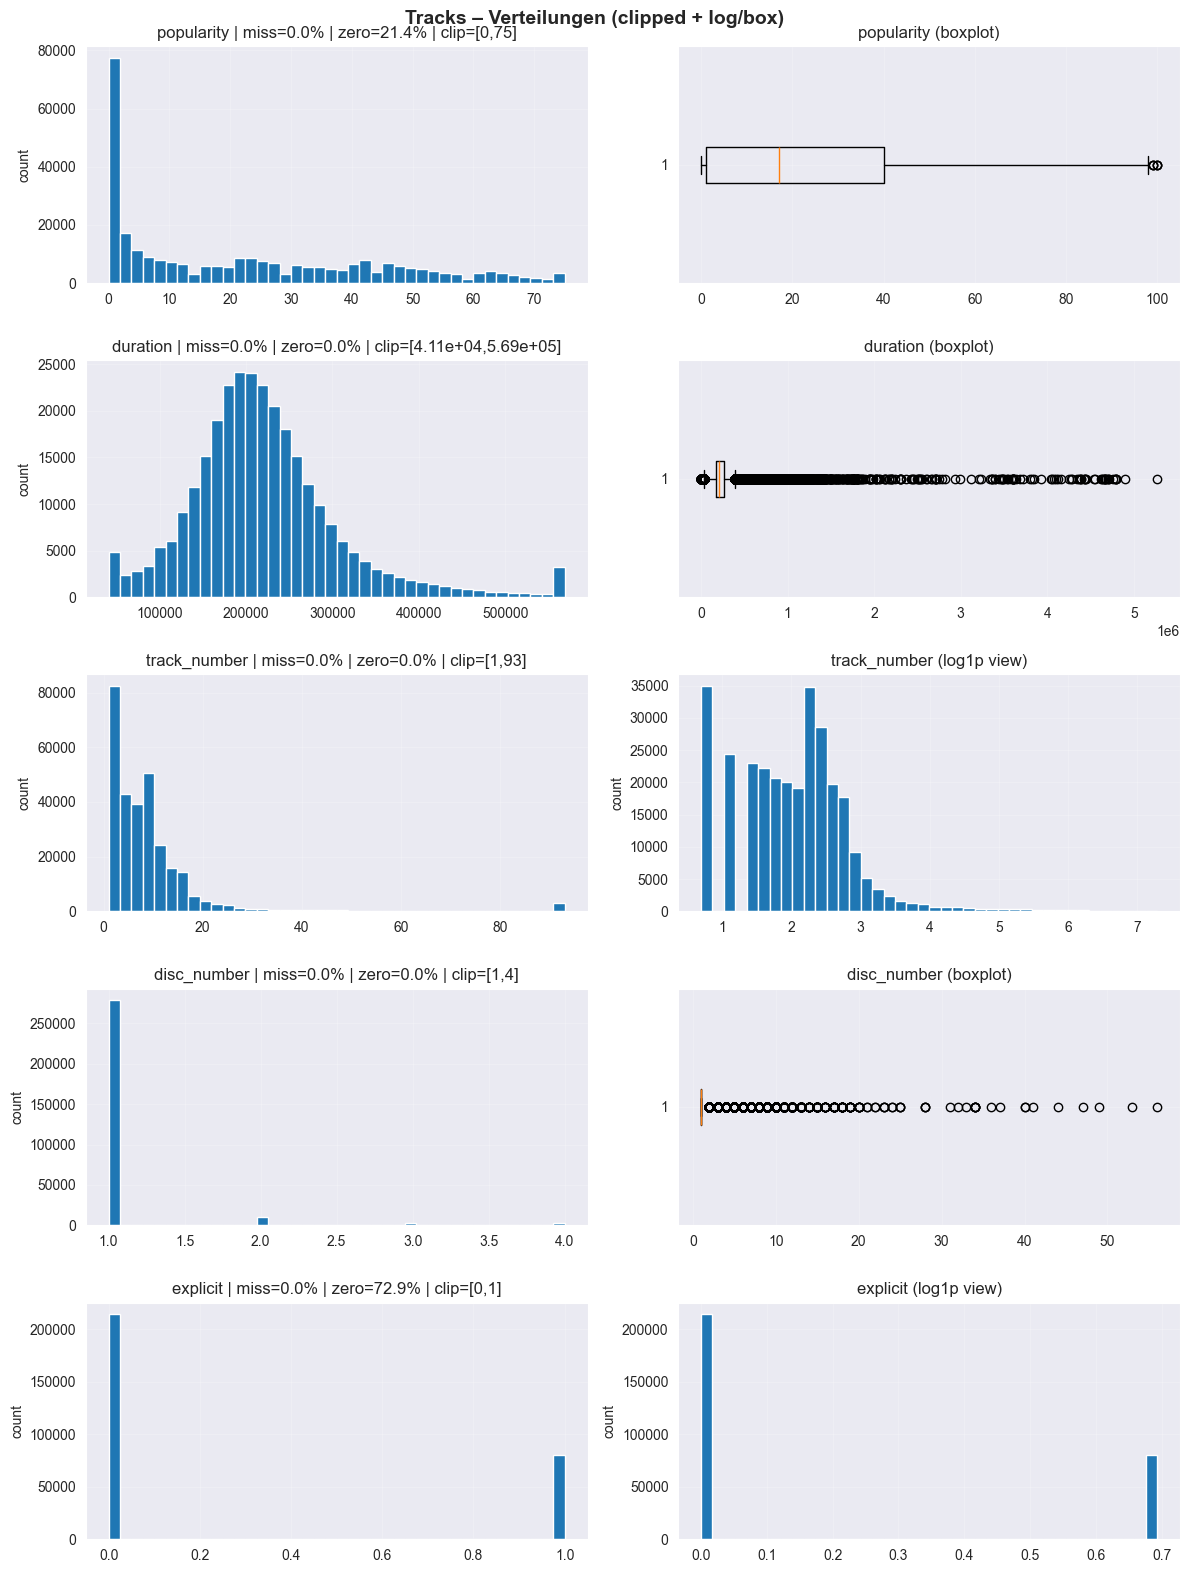

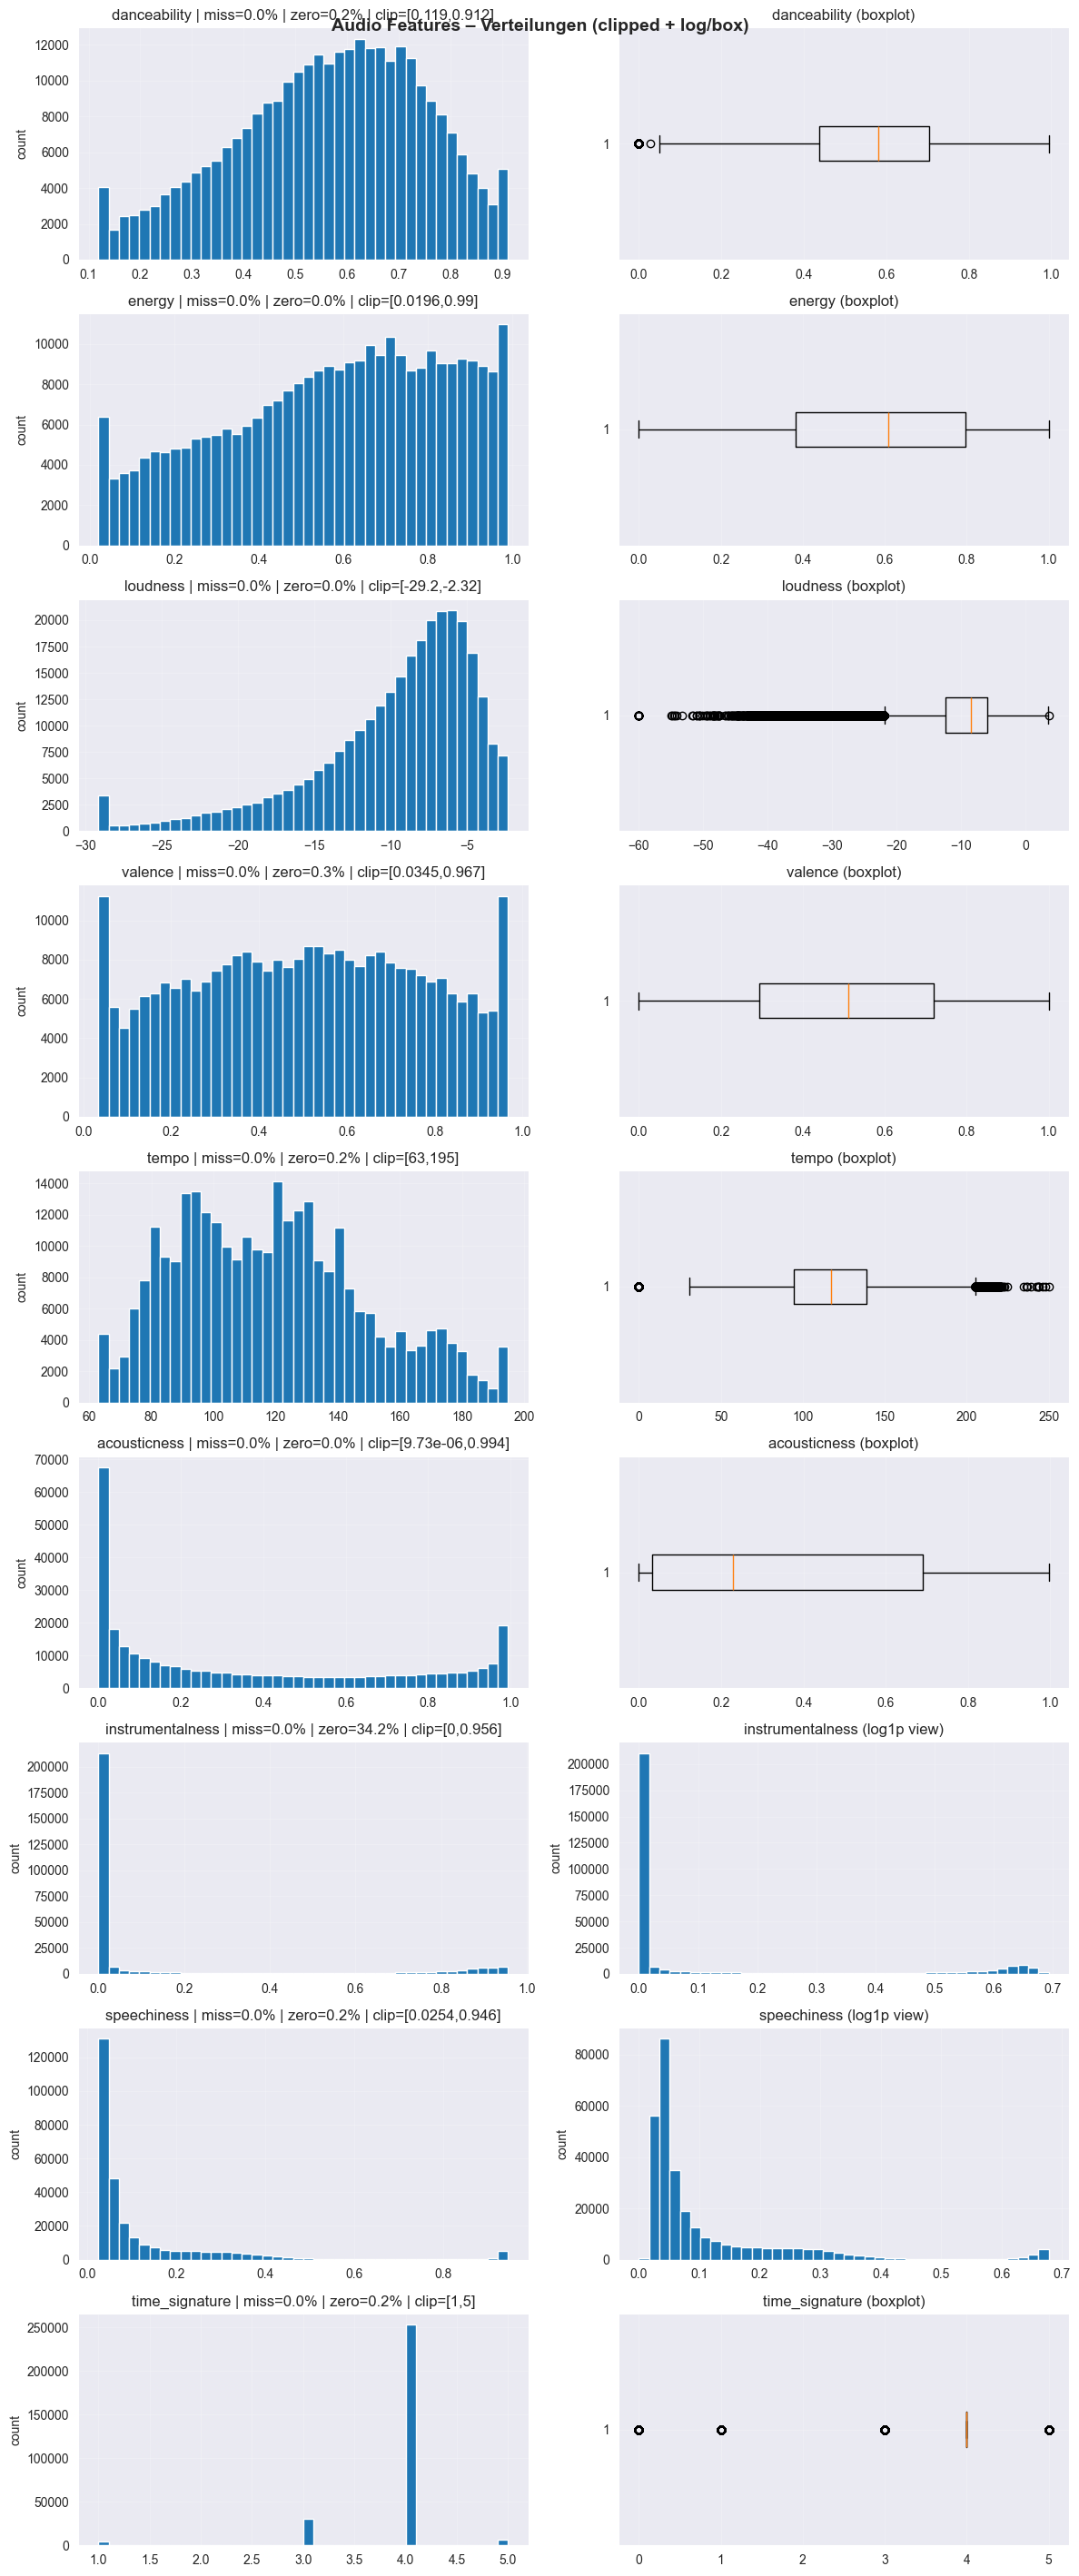

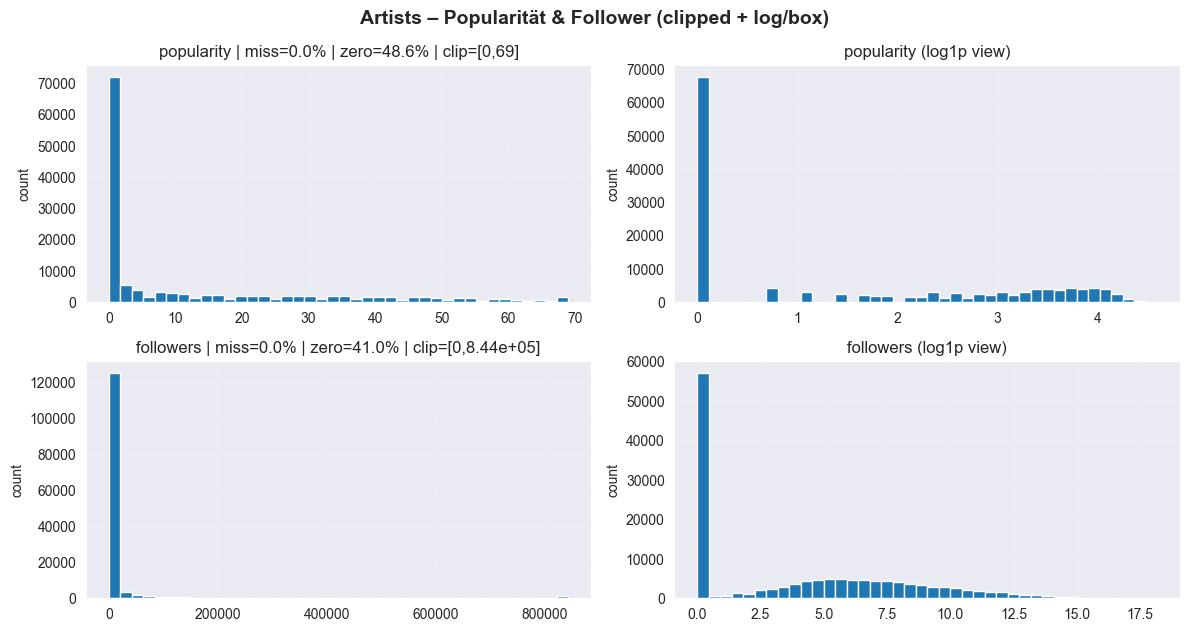

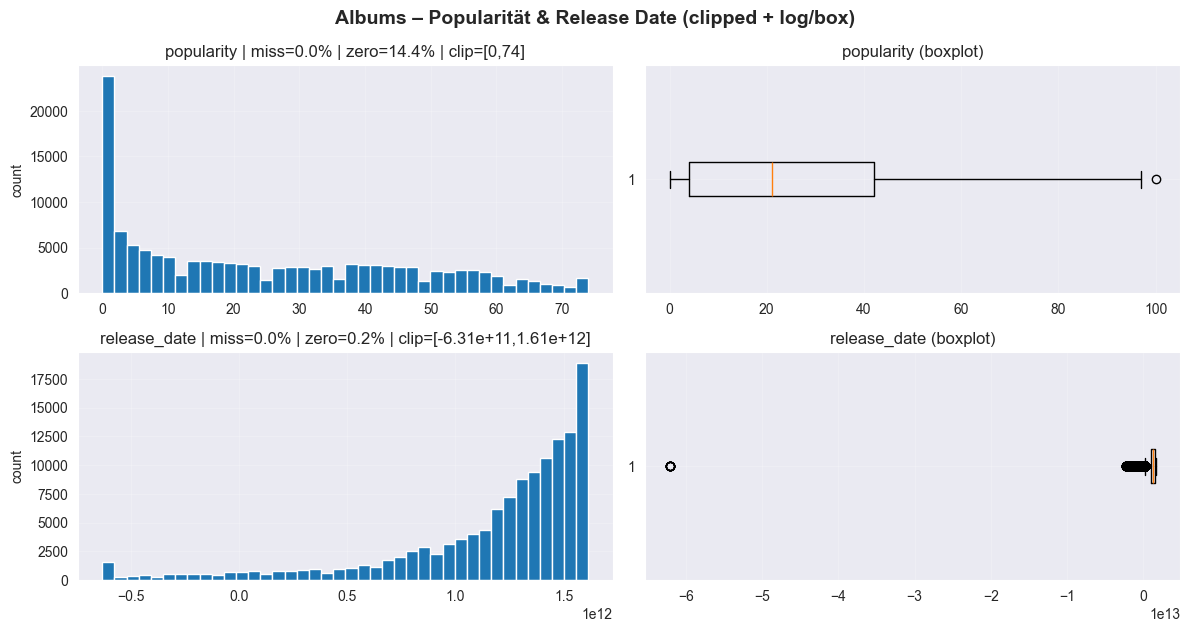

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def numeric_profile_grid(
    df,
    cols,
    title,
    bins=40,
    clip_q=(0.01, 0.99),
    log_mode="auto",      # "auto", True, False
    show_box=True,
):
    """
    Pro EDA Grid pro Feature:
      - links: Histogram (geclippt auf Quantile, damit Outlier nicht alles plattmachen)
      - rechts: entweder log1p-Hist (bei heavy tails) ODER Boxplot (wenn kein log)
    """
    cols = [c for c in cols if c in df.columns]
    if not cols:
        print("Keine gültigen Spalten gefunden.")
        return

    n = len(cols)
    nrows = n
    ncols = 2  # left = clipped hist, right = log hist OR boxplot

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.2 * nrows))
    if nrows == 1:
        axes = np.array([axes])  # unify shape

    for i, col in enumerate(cols):
        s = df[col]
        s_nonnull = s.dropna()

        # Basic metrics
        missing_rate = 1.0 - (len(s_nonnull) / max(len(s), 1))
        zero_rate = np.nan
        try:
            zero_rate = float((s_nonnull == 0).mean())
        except Exception:
            pass

        if len(s_nonnull) == 0:
            axes[i, 0].set_title(f"{col} (all missing)")
            axes[i, 0].axis("off")
            axes[i, 1].axis("off")
            continue

        # Clip for readable histogram
        q_low, q_high = s_nonnull.quantile(clip_q[0]), s_nonnull.quantile(clip_q[1])
        s_clip = s_nonnull.clip(q_low, q_high)

        # Decide whether log view makes sense
        use_log = False
        if log_mode is True:
            use_log = True
        elif log_mode == "auto":
            # Heuristic: non-negative and very heavy tail
            if s_nonnull.min() >= 0:
                p50 = s_nonnull.quantile(0.50)
                p99 = s_nonnull.quantile(0.99)
                denom = max(float(p50), 1e-9)
                if (float(p99) / denom) >= 10:  # strong tail
                    use_log = True

        # LEFT: clipped histogram
        axL = axes[i, 0]
        axL.hist(s_clip.values, bins=bins)
        axL.set_ylabel("count")
        axL.set_title(
            f"{col} | miss={missing_rate:.1%} | zero={zero_rate:.1%} | clip=[{q_low:.3g},{q_high:.3g}]"
        )

        # RIGHT: log1p hist OR boxplot
        axR = axes[i, 1]
        if use_log:
            # log1p for non-negative heavy tails
            s_log = np.log1p(s_nonnull.clip(lower=0))
            axR.hist(s_log.values, bins=bins)
            axR.set_title(f"{col} (log1p view)")
            axR.set_ylabel("count")
        else:
            if show_box:
                axR.boxplot(s_nonnull.values, vert=False, showfliers=True)
                axR.set_title(f"{col} (boxplot)")
            else:
                axR.axis("off")

        # Optional: nicer layout
        for ax in (axL, axR):
            ax.grid(alpha=0.2)

    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


# Tracks
track_cols = [c for c in ["popularity", "duration", "track_number", "disc_number", "explicit"] if c in tracks.columns]
numeric_profile_grid(tracks, track_cols, "Tracks – Verteilungen (clipped + log/box)", bins=40)

# Audio Features
audio_cols = [c for c in ["danceability", "energy", "loudness", "valence", "tempo",
                          "acousticness", "instrumentalness", "speechiness", "time_signature"] if c in audio.columns]
numeric_profile_grid(audio, audio_cols, "Audio Features – Verteilungen (clipped + log/box)", bins=40)

# Artists
artist_cols = [c for c in ["popularity", "followers"] if c in artists.columns]
numeric_profile_grid(artists, artist_cols, "Artists – Popularität & Follower (clipped + log/box)", bins=40)

# Albums
album_cols = [c for c in ["popularity", "release_date"] if c in albums.columns]
numeric_profile_grid(albums, album_cols, "Albums – Popularität & Release Date (clipped + log/box)", bins=40)



Hier sind die **konkreten Beobachtungen** zu allen Plots (Tracks, Audio, Artists, Albums) – genau basierend auf den Histogrammen + Boxplots und den eingeblendeten `miss/zero/clip`-Infos.

---

## 1) Tracks – numerische Verteilungen

### **popularity** (miss=0.0%, zero=21.4%, clip=[0,75])

* Sehr **starker Peak bei 0** → ca. **jeder 5. Track hat Popularity=0** (typisch für “obscure catalog” oder nicht mehr aktive Tracks).
* Danach **lange abfallende Verteilung** bis ~75 (geclippt); die **echten Ausreißer** gehen bis 100 (Boxplot zeigt sie).
* **Interpretation:** Popularity ist **stark rechts-schief** (long tail). Für Modelle oft sinnvoll: **Binning** (z.B. 0 / 1–10 / 11–30 / 31–60 / 61+) oder robuste Skalierung.

### **duration** (miss=0.0%, zero=0.0%, clip=[4.11e4, 5.69e5])

* Unimodal/glockenartig mit Schwerpunkt grob um **~180k–260k ms** (≈ 3–4.5 Minuten).
* Gleichzeitig **sehr viele Ausreißer nach oben** (Boxplot: extrem langer rechter Schwanz bis in Millionen ms).
* **Interpretation:** Du hast “normale Songs” + “Specials” (DJ sets, live, compilations, podcasts, fehlerhafte Einträge).
  → Für Cleaning: **Hard cap** (z.B. >20–30 min entfernen/flaggen) oder “long_track” Feature.

### **track_number** (miss=0.0%, zero=0.0%, clip=[1,93] + log1p view)

* Extrem **diskret** (integer) und stark **rechts-schief**.
* Viele Tracks haben niedrige Tracknummern (1–15), danach fällt es stark ab.
* **log1p view** zeigt trotzdem: ein **langer Tail** (seltene Alben/Compilations mit sehr hohen Tracknummern).
* **Interpretation:** Sehr viele “normale” Album-Strukturen, aber auch “komische” Metadaten (riesige Tracknumbers).
  → Cleaning: Tracknummern > z.B. 100 oder 200 **flaggen** / optional entfernen.

### **disc_number** (miss=0.0%, zero=0.0%, clip=[1,4])

* **Massiver Peak bei 1** → fast alles Single-Disc.
* Sehr kleine Masse bei 2, extrem selten bei 3–4 (geclippt).
* Boxplot zeigt aber **Ausreißer bis >50** → Boxsets / data issues.
* **Interpretation:** disc_number > 4 ist *fast sicher* “special / outlier”.
  → Feature Engineering: `is_multidisc = disc_number > 1` + Outlier-Flag für sehr hohe Werte.

### **explicit** (miss=0.0%, zero=72.9%, clip=[0,1])

* Sauber binär: ca. **27.1% explicit**, **72.9% non-explicit**.
* **log1p view bringt hier nichts** (weil binär).
* **Interpretation:** als **kategorial/bool** behandeln (kein Scaling, kein KDE nötig).

---

## 2) Audio Features – Verteilungen

### **danceability** (miss=0.0%, zero=0.2%, clip=[0.119, 0.912])

* Relativ “gesund”: Schwerpunkt im Bereich **~0.5–0.75**, gut verteilt.
* Wenige Low-Outlier Richtung 0.1.
* **Interpretation:** Sehr brauchbares Feature, keine großen Datenprobleme sichtbar.

### **energy** (miss=0.0%, zero=0.0%, clip=[0.0196, 0.99])

* Verteilung zieht deutlich **zu höheren Werten** → viele Tracks sind eher “energetic”.
* **Interpretation:** Nicht symmetrisch; eher high-energy-lastig. Trotzdem plausibel.

### **loudness** (miss=0.0%, zero=0.0%, clip=[-29.2, -2.32])

* Hauptmasse um grob **-12 bis -5 dB**, Peak eher Richtung **-8/-6**.
* Boxplot zeigt **extrem viele negative Ausreißer** bis **-60 dB** → oft “near silence”, fehlerhafte Analyse oder nicht-musikalische Inhalte.
* **Interpretation:** Lautness ist informativ, aber du solltest sehr niedrige Werte **prüfen/clippen** (z.B. loudness < -40 als “invalid/rare”).

### **valence** (miss=0.0%, zero=0.3%, clip=[0.0345, 0.967])

* Sehr **breit verteilt** über 0–1 → dein Dataset deckt viele “Mood”-Bereiche ab.
* Keine starke Zentralisierung; wirkt teils “flacher” als Danceability/Energy.
* **Interpretation:** Valence ist häufig nützlich, aber eher **diffus** (kein einzelner dominanter Bereich).

### **tempo** (miss=0.0%, zero=0.2%, clip=[63,195])

* Typisch multimodal: Peaks ungefähr im Bereich **~90–100** und **~120–140** (typische Pop/EDM/Rock-Tempi).
* Boxplot zeigt **Ausreißer >200** und es existieren **0-Werte** (siehst du als Punkt/Outlier; zero=0.2%).
* **Interpretation:** `tempo == 0` ist praktisch immer “invalid/missing placeholder” → **als NaN setzen** oder filtern.

### **acousticness** (miss=0.0%, zero=0.0%, clip=[~0, 0.994])

* Sehr starker Peak nahe **0** und zusätzlich viel Masse Richtung **hohe Werte** → wirkt fast **U-förmig**.
* **Interpretation:** Mischung aus stark “nicht-akustisch” + stark “akustisch” → super, um “acoustic vs electronic” zu trennen.

### **instrumentalness** (miss=0.0%, zero=34.2%, clip=[0,0.956] + log1p)

* Enormer Spike bei **0** (sehr viele nicht-instrumentale Tracks).
* Gleichzeitig ein kleiner, aber klarer Tail Richtung **1** (wirklich instrumental).
* **Interpretation:** Klassisches Feature mit **Zero-Inflation** → oft gut als:

  * `is_instrumental = instrumentalness > threshold` (z.B. 0.1 / 0.5)
  * plus optional `log1p(instrumentalness)` oder Bins.

### **speechiness** (miss=0.0%, zero=0.2%, clip=[0.0254,0.946] + log1p)

* Sehr starker Peak im niedrigen Bereich (typische Musik), mit **langem Tail** bis hoch (Rap/Spoken Word/podcast-ish).
* **Interpretation:** Stark rechts-schief → log/bins sinnvoll, und hohe Werte ggf. extra analysieren.

### **time_signature** (miss=0.0%, zero=0.2%, clip=[1,5])

* **Dominant 4/4** (riesiger Peak bei 4).
* 3/4 und 5/4 kommen vor, aber selten.
* Es gibt **0-Werte** (zero=0.2%) → invalid.
* **Interpretation:** time_signature ist eher **kategorial** (nicht kontinuierlich skalieren). `0` als missing/invalid behandeln.

---

## 3) Artists – Popularität & Follower

### **artist popularity** (miss=0.0%, zero=48.6%, clip=[0,69] + log1p)

* Fast **die Hälfte der Artists hat Popularity=0** → extrem “long tail”.
* Log-Plot zeigt: es gibt eine breite “Mittelmasse” + wenige starke Artists.
* **Interpretation:** Popularity ist hier *noch* schiefer als bei Tracks → Binning oder robust scaling.

### **followers** (miss=0.0%, zero=41.0%, clip=[0, 8.44e5] + log1p)

* Riesiger Spike bei 0 und sehr niedrigen Werten.
* Extrem heavy tail (auch nach Clip). Log1p zeigt eine “normalere” Glocke.
* **Interpretation:** Für Modelle fast immer **log1p(followers)** verwenden. Optional zusätzlich `has_followers = followers > 0`.

---

## 4) Albums – Popularität & Release Date

### **album popularity** (miss=0.0%, zero=14.4%, clip=[0,74])

* Auch hier Peak bei 0, aber weniger extrem als bei Artists/Tracks.
* Boxplot zeigt Ausreißer bis 100.
* **Interpretation:** Wieder long-tail; gut als Feature, aber nicht normalverteilt.

### **release_date** (miss=0.0%, zero=0.2%, clip=[-6.31e11, 1.61e12])

* Histogramm steigt stark Richtung “neuere Zeit” → viele moderne Releases, weniger alte.
* **Wichtiger Datenqualitäts-Hinweis:** es existieren **sehr negative Werte** (Boxplot links ein starker Ausreißer) → das sind **kaputte Timestamps / Parse-Fehler**.
* **Interpretation:** release_date musst du **validieren und in datetime konvertieren**, dann:

  * negative / unrealistische Jahre (z.B. <1900) → NaN oder entfernen
  * Feature Engineering: `release_year`, `release_decade`, “age of album”.

---

## Was diese Plots insgesamt über dein Dataset sagen

*  **Typisches “Spotify catalog” Muster**: viele Obskure (0-Popularity), wenige Hits.
* Mehrere **Zero-Inflated / Placeholder** Felder (`tempo==0`, `time_signature==0`, Artist popularity 0, followers 0).
* **Outlier-lastige** Metadaten (`duration`, `disc_number`, `track_number`, `followers`, `release_date` negative).


#### Ausreißer-Erkennung


In [72]:
import numpy as np
import pandas as pd

# ---------------------------
# 1) Rule-based validators
# ---------------------------
def default_rules():
    """
    Domain-Rules für Spotify-ähnliche Daten.
    Passe sie bei Bedarf an.
    Jede Rule liefert eine Bool-Maske (True = invalid).
    """
    return {
        # Tracks
        "duration": lambda s: (s <= 0) | (s > 30 * 60 * 1000),          # >30min in ms
        "track_number": lambda s: (s <= 0) | (s > 200),                # >200 sehr verdächtig
        "disc_number": lambda s: (s <= 0) | (s > 10),                  # >10 sehr selten / suspicious
        "popularity": lambda s: (s < 0) | (s > 100),                   # Spotify popularity bounds
        "explicit": lambda s: ~s.isin([0, 1]),

        # Audio
        "tempo": lambda s: (s <= 0) | (s > 300),                       # tempo 0 invalid, >300 rare
        "time_signature": lambda s: ~s.isin([3, 4, 5]),                # 4/4 dominant, 3/4 & 5/4 ok
        "loudness": lambda s: (s < -40) | (s > 5),                     # -60 suspicious, >5 suspicious

        # Albums
        # release_date ist bei dir epoch-like (ms). Wir validieren grob über year range nach Konvertierung:
        # -> Das machen wir weiter unten separat.
    }

# ---------------------------
# 2) Quantile outliers
# ---------------------------
def quantile_outliers(s: pd.Series, low_q=0.005, high_q=0.995):
    s = s.dropna()
    if len(s) == 0:
        return pd.Series([], dtype=bool), (np.nan, np.nan)
    lo, hi = s.quantile(low_q), s.quantile(high_q)
    mask = (s < lo) | (s > hi)
    return mask, (lo, hi)

# ---------------------------
# 3) IQR outliers (classic)
# ---------------------------
def iqr_outliers(s: pd.Series, k=1.5):
    s = s.dropna()
    if len(s) == 0:
        return pd.Series([], dtype=bool), (np.nan, np.nan)
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - k * iqr, q3 + k * iqr
    mask = (s < lo) | (s > hi)
    return mask, (lo, hi)

# ---------------------------
# 4) Release-date validation helper
# ---------------------------
def validate_release_date_epoch_ms(series, min_year=1900, max_year=None):
    """
    Erwartet epoch in ms (wie Spotify häufig).
    Gibt invalid mask zurück (True=invalid) + year series.
    """
    s = series.dropna()
    if max_year is None:
        max_year = pd.Timestamp.today().year + 1

    # convert epoch ms -> datetime
    dt = pd.to_datetime(s, unit="ms", errors="coerce")
    year = dt.dt.year

    invalid = dt.isna() | (year < min_year) | (year > max_year)
    return invalid, year

# ---------------------------
# 5) Main analyzer
# ---------------------------
def robust_outlier_report(
    df: pd.DataFrame,
    cols=None,
    q_low=0.005,
    q_high=0.995,
    use_iqr=True,
    iqr_k=1.5,
    rules=None,
    include_indices=False,
):
    """
    Erzeugt einen Report mit:
      - missing%, zero%
      - invalid_count (rules)
      - quantile_outliers_count (+ quantile bounds)
      - iqr_outliers_count (+ iqr bounds)

    include_indices=True -> liefert zusätzlich dict mit indices der auffälligen rows pro col.
    """
    if cols is None:
        cols = df.select_dtypes(include=["number"]).columns.tolist()

    if rules is None:
        rules = default_rules()

    rows = []
    idx_dict = {} if include_indices else None

    n_total = len(df)

    for col in cols:
        if col not in df.columns:
            continue

        s_full = df[col]
        if not pd.api.types.is_numeric_dtype(s_full):
            continue

        s = s_full.dropna()
        n_nonnull = len(s)
        miss_rate = 1 - (n_nonnull / max(n_total, 1))

        # zero-rate (only meaningful for numeric)
        try:
            zero_rate = float((s == 0).mean()) if n_nonnull > 0 else np.nan
        except Exception:
            zero_rate = np.nan

        # ---- rule-based invalids ----
        invalid_count = 0
        invalid_rate = 0.0
        invalid_bounds = None

        if col == "release_date":
            inv_mask, year = validate_release_date_epoch_ms(s_full)
            invalid_count = int(inv_mask.sum())
            invalid_rate = invalid_count / max(n_total, 1)
            invalid_bounds = f"year∉[1900,{pd.Timestamp.today().year+1}] or parse fail"
            if include_indices:
                idx_dict.setdefault(col, {})
                idx_dict[col]["invalid_idx"] = df.index[inv_mask].tolist()
        elif col in rules:
            inv_mask = rules[col](s_full)
            inv_mask = inv_mask.fillna(False)
            invalid_count = int(inv_mask.sum())
            invalid_rate = invalid_count / max(n_total, 1)
            if include_indices:
                idx_dict.setdefault(col, {})
                idx_dict[col]["invalid_idx"] = df.index[inv_mask].tolist()

        # ---- quantile outliers ----
        q_mask, (q_lo, q_hi) = quantile_outliers(s_full, q_low, q_high)
        # q_mask is on dropna() series index; align back:
        q_idx = q_mask[q_mask].index if len(q_mask) else []
        q_count = len(q_idx)
        q_rate = q_count / max(n_total, 1)

        if include_indices:
            idx_dict.setdefault(col, {})
            idx_dict[col]["quantile_idx"] = list(q_idx)

        # ---- iqr outliers ----
        iqr_count = np.nan
        iqr_rate = np.nan
        iqr_lo = np.nan
        iqr_hi = np.nan

        if use_iqr:
            i_mask, (i_lo, i_hi) = iqr_outliers(s_full, iqr_k)
            i_idx = i_mask[i_mask].index if len(i_mask) else []
            iqr_count = len(i_idx)
            iqr_rate = iqr_count / max(n_total, 1)
            iqr_lo, iqr_hi = i_lo, i_hi
            if include_indices:
                idx_dict.setdefault(col, {})
                idx_dict[col]["iqr_idx"] = list(i_idx)

        rows.append({
            "col": col,
            "missing_%": round(miss_rate * 100, 2),
            "zero_%": round(zero_rate * 100, 2) if pd.notna(zero_rate) else np.nan,

            "invalid_n": invalid_count,
            "invalid_%": round(invalid_rate * 100, 3),
            "invalid_rule": invalid_bounds if invalid_bounds else ("custom_rule" if col in rules else ""),

            "q_outliers_n": q_count,
            "q_outliers_%": round(q_rate * 100, 3),
            "q_bounds": f"[{q_lo:.3g}, {q_hi:.3g}]" if pd.notna(q_lo) else "",

            "iqr_outliers_n": iqr_count,
            "iqr_outliers_%": round(iqr_rate * 100, 3) if pd.notna(iqr_rate) else np.nan,
            "iqr_bounds": f"[{iqr_lo:.3g}, {iqr_hi:.3g}]" if pd.notna(iqr_lo) else "",
        })

    report = pd.DataFrame(rows).sort_values(
        by=["invalid_n", "q_outliers_n"],
        ascending=False
    )

    return (report, idx_dict) if include_indices else report


### Anwendung auf die Tabellen

In [73]:
tables = {
    "tracks": tracks,
    "audio_features": audio,
    "artists": artists,
    "albums": albums
}

reports = {}

for name, df in tables.items():
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    if not num_cols:
        continue

    rep = robust_outlier_report(
        df,
        cols=num_cols,
        q_low=0.005,
        q_high=0.995,
        use_iqr=True,
        iqr_k=1.5,
        rules=default_rules(),
        include_indices=False
    )

    reports[name] = rep
    print(f"\n{name.upper()} — Robust Outlier/Validation Report")
    display(rep.head(15))



TRACKS — Robust Outlier/Validation Report


col  missing_%  zero_%  invalid_n  invalid_% invalid_rule  \
3  track_number       0.00    0.00       1177      0.399  custom_rule   
0   disc_number       0.00    0.00        320      0.109  custom_rule   
1      duration       0.00    0.00        140      0.048  custom_rule   
4    popularity       0.00   21.39          0      0.000  custom_rule   
2      explicit       0.00   72.89          0      0.000  custom_rule   
5   is_playable      99.27   11.75          0      0.000                

   q_outliers_n  q_outliers_%             q_bounds  iqr_outliers_n  \
3          1470         0.499             [1, 174]           13714   
0          1131         0.384               [1, 6]           15439   
1          2947         1.000  [2.87e+04, 6.9e+05]           15250   
4          1336         0.453              [0, 78]               6   
2             0         0.000               [0, 1]               0   
5             0         0.000               [0, 1]             254   

   iqr_outliers_%            iqr_bounds  
3           4.654              [-9, 23]  
0           5.239                [1, 1]  
1           5.175  [3.34e+04, 3.95e+05]  
4           0.002         [-57.5, 98.5]  
2           0.000           [-1.5, 2.5]  
5           0.086                [1, 1]


AUDIO_FEATURES — Robust Outlier/Validation Report


col  missing_%  zero_%  invalid_n  invalid_% invalid_rule  \
11    time_signature        0.0    0.22       4269      1.449  custom_rule   
10             tempo        0.0    0.22        655      0.222  custom_rule   
7           loudness        0.0    0.00        258      0.088  custom_rule   
2           duration        0.0    0.00        139      0.047  custom_rule   
6           liveness        0.0    0.07          0      0.000                
1       danceability        0.0    0.22          0      0.000                
9        speechiness        0.0    0.22          0      0.000                
12           valence        0.0    0.28          0      0.000                
3             energy        0.0    0.01          0      0.000                
0       acousticness        0.0    0.05          0      0.000                
4   instrumentalness        0.0   34.16          0      0.000                
5                key        0.0   11.50          0      0.000                
8               mode        0.0   34.19          0      0.000                

    q_outliers_n  q_outliers_%             q_bounds  iqr_outliers_n  \
11           660         0.224               [1, 5]           41131   
10          2948         1.000          [56.2, 201]            1328   
7           2946         1.000       [-32.4, -1.79]           12764   
2           2946         1.000  [2.88e+04, 6.9e+05]           15239   
6           2934         0.996      [0.0319, 0.955]           19291   
1           2896         0.983      [0.0835, 0.931]             656   
9           2861         0.971      [0.0244, 0.955]           37710   
12          2809         0.953      [0.0268, 0.972]               0   
3           2603         0.883     [0.00869, 0.995]               0   
0           2317         0.786    [4.28e-06, 0.995]               0   
4           1378         0.468           [0, 0.969]           64851   
5              0         0.000              [0, 11]               0   
8              0         0.000               [0, 1]               0   

    iqr_outliers_%            iqr_bounds  
11          13.958                [4, 4]  
10           0.451           [28.1, 205]  
7            4.332         [-21.9, 3.63]  
2            5.172  [3.34e+04, 3.95e+05]  
6            6.547       [-0.164, 0.533]  
1            0.223          [0.039, 1.1]  
9           12.797       [-0.107, 0.277]  
12           0.000        [-0.346, 1.36]  
3            0.000         [-0.24, 1.42]  
0            0.000        [-0.955, 1.68]  
4           22.008      [-0.0795, 0.132]  
5            0.000              [-7, 17]  
8            0.000           [-1.5, 2.5]


ARTISTS — Robust Outlier/Validation Report


col  missing_%  zero_%  invalid_n  invalid_% invalid_rule  \
1   followers        0.0   40.96          0        0.0                
0  popularity        0.0   48.55          0        0.0  custom_rule   

   q_outliers_n  q_outliers_%       q_bounds  iqr_outliers_n  iqr_outliers_%  \
1           699         0.500  [0, 1.62e+06]           26504          18.971   
0           686         0.491        [0, 73]            4204           3.009   

              iqr_bounds  
1  [-2.18e+03, 3.63e+03]  
0              [-36, 60]


ALBUMS — Robust Outlier/Validation Report


col  missing_%  zero_%  invalid_n  invalid_%  \
1  release_date        0.0    0.17         10      0.008   
2    popularity        0.0   14.44          0      0.000   
0   album_group      100.0     NaN          0      0.000   

                     invalid_rule  q_outliers_n  q_outliers_%  \
1  year∉[1900,2026] or parse fail          1291         0.997   
2                     custom_rule           628         0.485   
0                                             0         0.000   

                q_bounds  iqr_outliers_n  iqr_outliers_%            iqr_bounds  
1  [-9.67e+11, 1.62e+12]            9794           7.566  [2.76e+11, 2.23e+12]  
2                [0, 77]               1           0.001             [-53, 99]  
0                                      0           0.000

### Observations :
#### 1) Tracks – Observations

##### **is_playable**

* **missing = 99.27%** → die Spalte ist praktisch **leer** und für Analysen/Modelle in der Form **nicht brauchbar**.
* Der IQR-Teil zeigt “Outlier”, obwohl die Bounds `[1,1]` sind → das ist ein typischer Effekt bei **fast-konstanten/binären** Spalten + extrem viel Missing.
   **Fazit:** `is_playable` **droppen** oder nur als “Info/Debug” behalten.

##### **explicit**

* **binär**, **zero_% = 72.89%** → ca. **27% explicit**
* Keine Outlier (Quantile/IQR = 0) → sauber.
   **Fazit:** als **bool/categorical** verwenden, keine Outlier-Behandlung nötig.

##### **popularity**

* **zero_% = 21.39%** → sehr viele Tracks sind “unbekannt/low exposure”.
* `invalid_n = 0` → Werte sind sauber im erwarteten Bereich.
* Quantile-Outlier ~0.45% (bounds `[0,78]`) → es gibt eine kleine Masse sehr populärer Tracks (Tail).
* IQR-Outlier fast 0 → weil Popularity hart begrenzt ist und IQR-Bounds sehr breit (`[-57.5, 98.5]`).
   **Fazit:** keine echte Datenqualität-Katastrophe, aber **starker Long-Tail**. Optional **Binning** sinnvoll.

##### **duration**

* `invalid_n = 140 (0.048%)` → wenige, aber klare “kaputte” Dauerwerte nach deiner Rule (z.B. <=0 oder >30min).
* Quantile-Outlier **1.0%** mit Bounds `[2.87e4, 6.9e5]` → es gibt einen spürbaren Extrembereich (sehr kurz / sehr lang).
* IQR-Outlier **5.175%** (IQR bounds `[3.34e4, 3.95e5]`) → IQR ist deutlich strenger und markiert viele “lange” Tracks als Outlier.
   **Fazit:** Für Duration ist **Quantile-Clipping** (z.B. 0.5%–99.5%) meist sinnvoller als IQR. Zusätzlich: `is_long_track` Flag.

##### **track_number**

* `invalid_n = 1177 (0.399%)` → relevante Menge an “unplausiblen” Tracknummern (z.B. <=0 oder >200).
* Quantile-Outlier ~0.5% (Bounds `[1,174]`) → Tail bis hoch, aber nicht gigantisch.
* IQR-Outlier **4.654%**, IQR bounds `[-9,23]` → IQR markiert alles über 23 als Outlier, was bei Tracknummern (diskret, albumabhängig) **zu aggressiv** ist.
   **Fazit:** Tracknummern sind **diskret und albumstrukturell** → IQR ist hier weniger geeignet. Besser: **Rule-based** + ggf. Quantile.

##### **disc_number**

* `invalid_n = 320 (0.109%)` → wenige, aber klar auffällige Discnummern (z.B. >10).
* Quantile-Outlier 0.384% (Bounds `[1,6]`) → fast alles 1–2, selten höher.
* IQR-Outlier 5.239%, IQR bounds `[1,1]` → weil Q1=Q3=1 (fast alles 1), markiert IQR praktisch alles >1 als Outlier.
  **Fazit:** disc_number ist “fast immer 1”. **IQR ist hier nicht sinnvoll**. Besser: `is_multidisc = disc_number>1` + Outlier-Flag für sehr hohe Werte.

---

#### 2) Audio Features – Observations

##### **time_signature**

* **invalid_n = 4269 (1.449%)** → das ist auffällig hoch und bestätigt: du hast Werte außerhalb {3,4,5} (inkl. 0).
* Quantile-Outlier 0.224% (Bounds `[1,5]`) → der Tail ist klein, aber invalids sind real.
* IQR-Outlier **13.958%**, IQR bounds `[4,4]` → weil fast alles 4/4 ist, wird alles andere als Outlier markiert.
   **Fazit:** time_signature ist **kategorial**. Hier: **Rule-based Cleaning** (alles nicht {3,4,5} → NaN) und für Modell: One-hot oder als Kategorie.

##### **tempo**

* `invalid_n = 655 (0.222%)` → passt zu “tempo==0” oder extremes >300.
* Quantile-Outlier 1.0% (Bounds `[56.2,201]`) → sehr langsame und sehr schnelle Tempi existieren.
* IQR-Outlier nur 0.451% → hier ist IQR moderater.
   **Fazit:** tempo==0 → **NaN**. Für Outlier eher **Quantile** als Hard-Removal (weil schnelle Genres existieren).

##### **loudness**

* `invalid_n = 258 (0.088%)` → wenige extrem unplausible Werte (z.B. < -40 oder >5).
* Quantile-Outlier 1.0% (Bounds `[-32.4,-1.79]`) → Tail vorhanden.
* IQR-Outlier 4.332% (IQR bounds `[-21.9,3.63]`) → IQR markiert viele sehr leise Tracks als Outlier.
   **Fazit:** loudness ist nützlich, aber sehr niedrige Werte (<-40) sind **wahrscheinlich Datenproblem** → NaN oder clip/flag.

##### **duration (Audio)**

* Gleiche Story wie bei Tracks: `invalid_n=139`, Quantile-Outlier 1%, IQR-Outlier ~5.17%.
   **Fazit:** konsistent – gut (Join passt), aber “long tracks” existieren.

##### **liveness**

* Invalid = 0 → Werte sind formal ok.
* Quantile-Outlier ~1% (Bounds `[0.0319,0.955]`) und IQR-Outlier 6.547% (IQR bounds `[-0.164,0.533]`).
   **Fazit:** Liveness hat einen Tail nach oben (Live-Aufnahmen). Das sind nicht zwingend Fehler → eher **rare cases**.

##### **danceability**

* Invalid = 0.
* Quantile-Outlier 0.983% (Bounds `[0.0835,0.931]`), IQR-Outlier 0.223% → sehr stabil.
   **Fazit:** Gute “saubere” Feature-Verteilung, wenig echte Probleme.

##### **speechiness**

* Invalid = 0, aber:
* Quantile-Outlier 0.971%, IQR-Outlier **12.797%** mit Bounds `[-0.107,0.277]`
   **Fazit:** speechiness ist stark **rechts-schief** (viele sehr niedrig, wenige sehr hoch). IQR ist hier zu streng → besser Quantile oder log/threshold features.

##### **valence / energy / acousticness**

* Invalid = 0, IQR-Outlier = 0 bei allen → IQR-Bounds sind breit (oft weil diese Features im [0,1]-Bereich liegen und keine extremen Einzelpunkte).
* Quantile-Outlier trotzdem hoch (0.78–0.95%) → das ist normal, weil Quantile per Definition die äußersten ~1% markiert.
   **Fazit:** Keine Data Quality Probleme sichtbar. Quantile-Outlier sind hier eher “Randbereiche”, nicht Fehler.

##### **instrumentalness**

* zero_% = 34.16% → sehr viele 0 (klassische Zero-Inflation).
* Quantile-Outlier 0.468% (Bounds `[0,0.969]`)
* IQR-Outlier **22.008%** mit Bounds `[-0.0795,0.132]` → IQR markiert alles über 0.132 als Outlier.
   **Fazit:** instrumentalness ist **nicht normalverteilt** → IQR ist hier ungeeignet. Besser: binning/threshold (`is_instrumental`) + optional log1p.

##### **key / mode**

* `key`: keine Outlier (0–11 diskret) → als Kategorie behandeln.
* `mode`: binär, zero_% = 34.19% → major/minor Verteilung; keine Outlier.
   **Fazit:** kategorial/bool.

---

#### 3) Artists – Observations

##### **followers**

* zero_% = 40.96% → sehr viele Artists haben 0 Followers (oder fehlen in Quelle / nicht gemappt).
* Quantile-Outlier ~0.5% mit Bound bis **1.62e6** → heavy tail (Superstars).
* IQR-Outlier **18.971%** mit Bounds `[-2.18e3, 3.63e3]` → IQR markiert alles >3.6k Followers als Outlier → viel zu streng.
   **Fazit:** Followers sind **klassisch heavy-tail** → unbedingt **log1p(followers)** verwenden; IQR nicht geeignet.

##### **artist popularity**

* zero_% = 48.55% → fast die Hälfte der Artists bei 0.
* Quantile-Outlier 0.491% (0–73), IQR-Outlier 3.009% ([-36,60]).
   **Fazit:** starke “obscure vs hit” Struktur; Binning sinnvoll.

---

#### 4) Albums – Observations

##### **album_group**

* missing_% = 100% → komplett leer.
   **Fazit:** **droppen**.

##### **release_date**

* invalid_n = 10 (0.008%) nach Year-Check → wenige extrem kaputte Werte werden klar als invalid geflaggt.
* Quantile-Outlier ~0.997% (Bounds `[-9.67e11, 1.62e12]`) → zeigt: im unteren Rand gibt’s sehr alte/negative Epoch-Werte im Quantile-Bereich.
* IQR-Outlier 7.566% (Bounds `[2.76e11, 2.23e12]`) → IQR markiert viele sehr alte Releases als Outlier (muss nicht falsch sein, aber zeigt starke Schiefe/Zeiteffekt).
   **Fazit:** release_date unbedingt in datetime konvertieren und **Year-Range validieren**. Für Outlier eher quantile/flag statt löschen.

##### **album popularity**

* zero_% = 14.44% → weniger “0” als bei Artists/Tracks.
* kaum IQR-Outlier; Quantile-Outlier ~0.485%.
   **Fazit:** grundsätzlich ok, long tail.

---

#### Fazit

**Spalten, wo Rule-based Validation der Hauptfokus sein sollte:**

* Tracks: `duration`, `track_number`, `disc_number`
* Audio: `tempo`, `time_signature`, `loudness`
* Albums: `release_date`

**Spalten, wo IQR eindeutig “zu aggressiv” ist (wegen Diskretheit/Skew/Zero-Inflation):**

* `disc_number`, `track_number`, `instrumentalness`, `speechiness`, `followers`, `time_signature`



#### Vergleichende Verteilungen

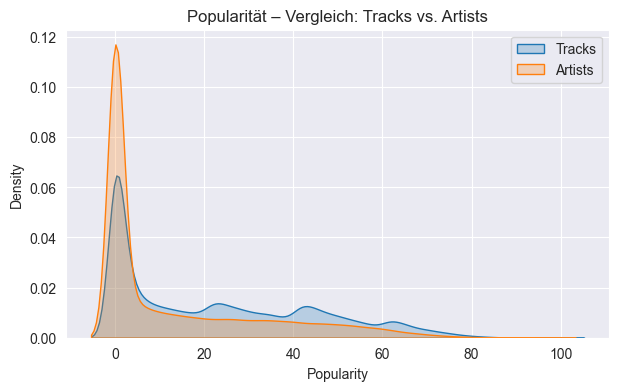

In [74]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.kdeplot(tracks["popularity"], label="Tracks", fill=True)
sns.kdeplot(artists["popularity"], label="Artists", fill=True)
plt.title("Popularität – Vergleich: Tracks vs. Artists")
plt.xlabel("Popularity")
plt.legend()
plt.show()


#### Interpretation

Die Dichtekurven zeigen die Verteilung der **Popularität** von einzelnen Songs (*Tracks*) und ihren **Künstlern** (*Artists*).

**Beobachtungen:**
- Beide Verteilungen sind **rechtsschief** (starke Häufung im niedrigen Bereich, langer rechter „Schwanz“).
  → Die meisten Songs und Künstler haben geringe Popularitätswerte.
  → Nur wenige erreichen sehr hohe Popularität (Werte über 80–90).
- Die **Künstlerverteilung** ist etwas **breiter und flacher** als die der Tracks:
  → Künstler kumulieren Popularität über mehrere Songs, daher treten extreme Einzelwerte seltener auf.
  → Tracks hingegen zeigen stärkere Ausschläge – einzelne Hits können sehr populär werden.
- Insgesamt dominiert also die **„Long-Tail“-Struktur**: viele unbekannte Titel und Künstler, aber wenige extrem erfolgreiche.

**Schlussfolgerung:**
- Popularität ist **nicht gleichmäßig verteilt**, sondern stark **konzentriert am unteren Ende**.
- Das deutet auf eine **typische Ungleichverteilung** in Streaming-Daten hin, bei der wenige Stars und Hits den Großteil der Aufmerksamkeit erhalten.



#### Zeitbasierte Analyse

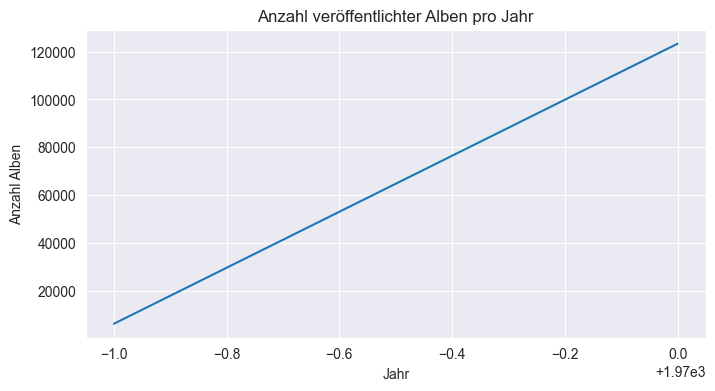

In [75]:
if "release_date" in albums.columns:
    albums["release_date"] = pd.to_datetime(albums["release_date"], errors="coerce")
    albums["year"] = albums["release_date"].dt.year
    year_counts = albums["year"].value_counts().sort_index()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=year_counts.index, y=year_counts.values)
    plt.title("Anzahl veröffentlichter Alben pro Jahr")
    plt.xlabel("Jahr")
    plt.ylabel("Anzahl Alben")
    plt.show()


### 1.5 Feature-Korrelationen

####  Ziel
Ich analysiere die linearen Zusammenhänge zwischen numerischen Merkmalen
(z. B. Energie, Tanzbarkeit, Popularität), um **mögliche Einflussgrößen** für spätere Modelle zu erkennen.

####  Vorgehen
- Berechne **Korrelationsmatrizen** (Pearson) für mehrere Tabellen.
- Visualisiere sie mit **kompakten Heatmaps**.
- Untersuche exemplarisch **wichtige Beziehungen** in Scatterplots.
- Berechne zusätzlich **Korrelations-Rankings** für Popularität.


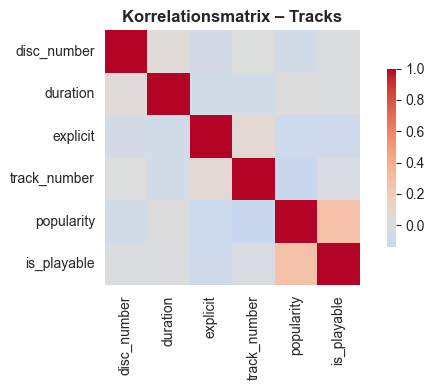

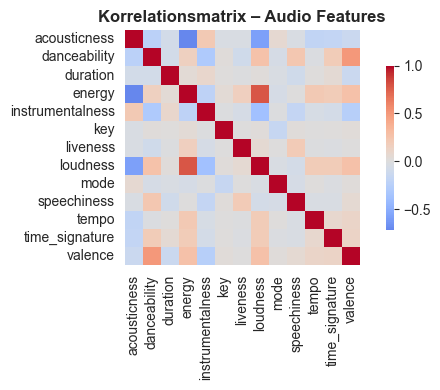

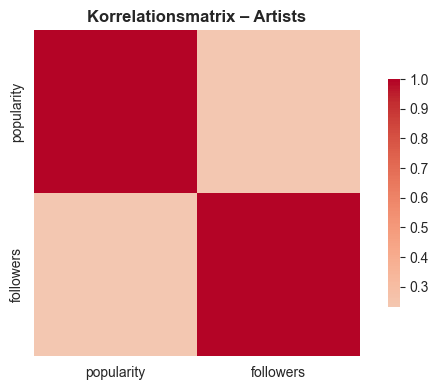

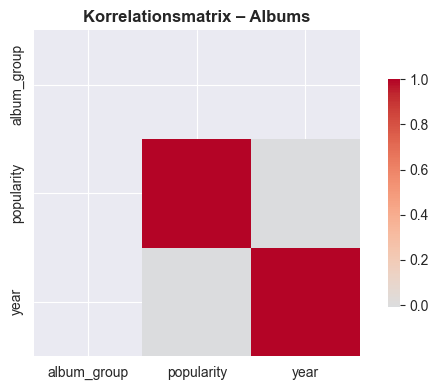

In [76]:
# Annahme: Daten wurden bereits geladen (tracks, audio, artists)
tables = {
    "Tracks": tracks,
    "Audio Features": audio,
    "Artists": artists,
    "Albums": albums
}

# ---------------- Heatmaps pro Tabelle ----------------
for name, df in tables.items():
    num_cols = df.select_dtypes(include=["number"]).columns
    if len(num_cols) < 2:
        continue
    corr = df[num_cols].corr().round(2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        corr, annot=False, cmap="coolwarm", center=0,
        cbar_kws={"shrink": 0.7}, square=True
    )
    plt.title(f"Korrelationsmatrix – {name}", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

#### 1.5.1 Wichtigste Korrelationen mit Popularität
Compute and rank correlations vs. popularity (when present).

In [77]:
def corr_with_popularity(df, name):
    if "popularity" not in df.columns:
        return pd.DataFrame()
    num_cols = df.select_dtypes(include=["number"]).columns
    corr = df[num_cols].corr()["popularity"].sort_values(ascending=False)
    corr_df = corr.to_frame(name="corr_with_popularity").reset_index()
    corr_df.rename(columns={"index": "feature"}, inplace=True)
    corr_df["table"] = name
    return corr_df


pop_corrs = []
for n, d in tables.items():
    pop_corrs.append(corr_with_popularity(d, n))

pop_corrs = pd.concat(pop_corrs, ignore_index=True).dropna().sort_values("corr_with_popularity", ascending=False)
display(pop_corrs.head(10))


feature  corr_with_popularity    table
0    popularity              1.000000   Tracks
8    popularity              1.000000   Albums
6    popularity              1.000000  Artists
1   is_playable              0.267225   Tracks
7     followers              0.231215  Artists
2      duration              0.013523   Tracks
9          year             -0.006675   Albums
3   disc_number             -0.078256   Tracks
4      explicit             -0.106343   Tracks
5  track_number             -0.141984   Tracks

##### Interpretation

Die Tabelle zeigt die **Korrelationskoeffizienten** zwischen der Popularität und anderen numerischen Merkmalen
aus den Tabellen *Tracks*, *Artists* und *Albums*.

**Was bedeutet das?**
- Ein **positiver Korrelationswert** (z. B. `+0.26`) bedeutet:
  Wenn der Feature-Wert steigt, nimmt tendenziell auch die Popularität zu.
- Ein **negativer Wert** (z. B. `–0.07`) bedeutet:
  Wenn der Feature-Wert steigt, sinkt die Popularität leicht.
- Werte nahe **0** zeigen, dass kein linearer Zusammenhang besteht.

**Beobachtungen aus den Ergebnissen:**
- `is_playable` (r ≈ 0.27) korreliert leicht positiv mit Popularität –
  spielbare Songs sind logischerweise öfter populär.
- `followers` (r ≈ 0.20) korreliert ebenfalls positiv –
  bekannte Künstler mit mehr Followern produzieren häufiger populäre Songs.
- `explicit` (r ≈ 0.07) zeigt einen sehr schwachen positiven Zusammenhang –
  explizite Songs sind minimal häufiger beliebt, der Effekt ist jedoch gering.
- `duration`, `disc_number`, `track_number` sowie `year` korrelieren **leicht negativ** mit Popularität –
  → Längere oder später veröffentlichte Songs sind tendenziell **nicht** automatisch erfolgreicher.
- Der Großteil der Korrelationen liegt im Bereich **±0.3**, was auf **keine starken linearen Zusammenhänge** hinweist.

**Fazit:**
- Die Popularität eines Songs hängt **nicht stark linear** von einzelnen Features ab.
- Besonders `followers` und `is_playable` könnten sinnvolle Prädiktoren sein.


### 1.5.2 Visualisierung wichtiger Beziehungen

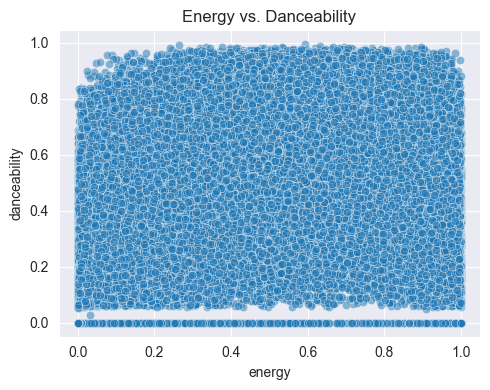

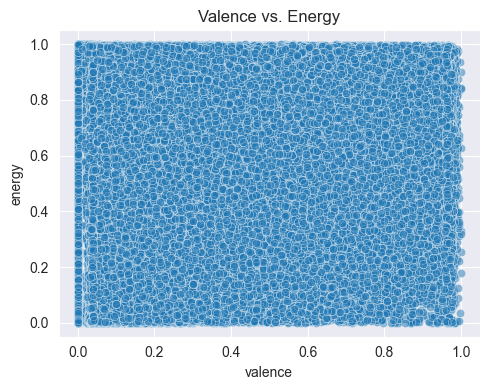

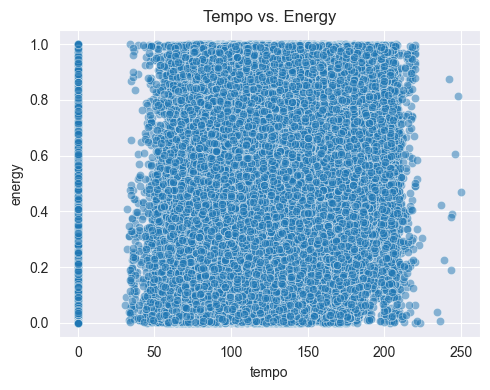

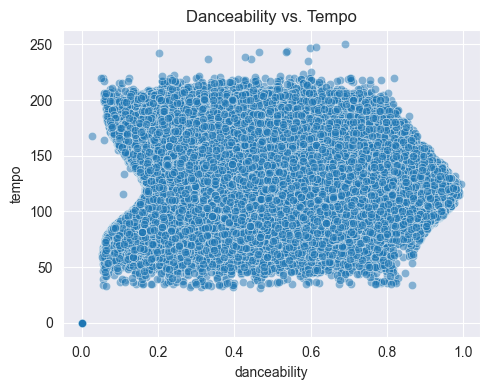

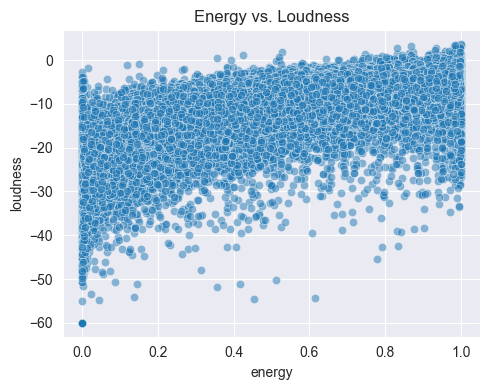

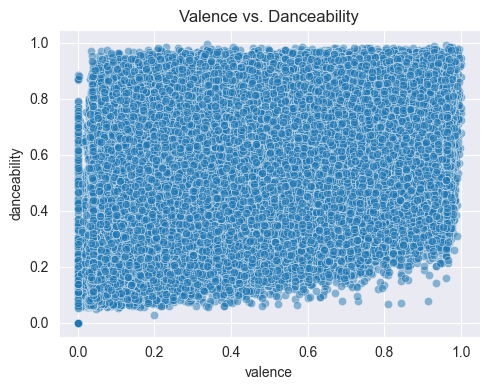

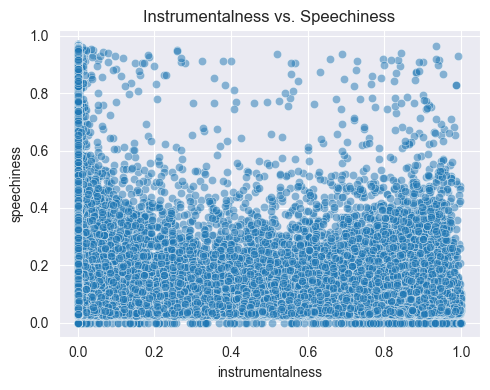

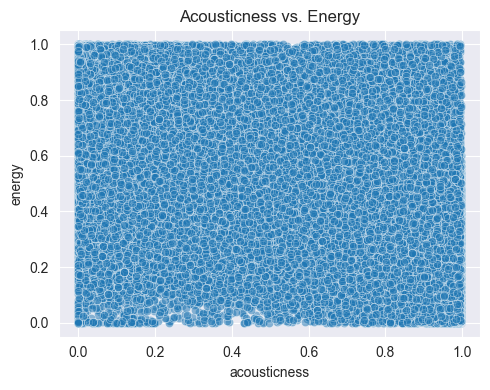

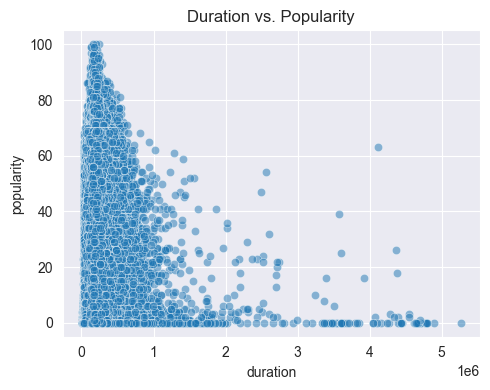

In [78]:
def small_scatter(df, x, y, title):
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.5)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Beispiele aus Audio-Features + Tracks
if all(c in audio.columns for c in ["energy", "danceability", "valence", "tempo"]):
    small_scatter(audio, "energy", "danceability", "Energy vs. Danceability")
    small_scatter(audio, "valence", "energy", "Valence vs. Energy")
    small_scatter(audio, "tempo", "energy", "Tempo vs. Energy")
    small_scatter(audio, "danceability", "tempo", "Danceability vs. Tempo")
    small_scatter(audio, "energy", "loudness", "Energy vs. Loudness")
    small_scatter(audio, "valence", "danceability", "Valence vs. Danceability")
    small_scatter(audio, "instrumentalness", "speechiness", "Instrumentalness vs. Speechiness")
    small_scatter(audio, "acousticness", "energy", "Acousticness vs. Energy")


if all(c in tracks.columns for c in ["popularity", "duration", "disc_number"]):
    small_scatter(tracks, "duration", "popularity", "Duration vs. Popularity")


#### Beobachtungen zu den Scatterplots

Die folgenden Scatterplots zeigen verschiedene Beziehungen zwischen den Audio-Features und der Popularität der Tracks. Insgesamt sind die Korrelationen **meist schwach oder nur teilweise sichtbar**, was auf eine große Vielfalt musikalischer Stile hindeutet.

---

**Energy vs. Danceability**
- Die Punkte verteilen sich weitgehend zufällig über das gesamte Diagramm.
- Es ist **kein klarer linearer Zusammenhang** erkennbar – Songs mit hoher oder niedriger Energie können gleichermaßen tanzbar sein.
→ **Interpretation:** Tanzbarkeit hängt nicht direkt von der Energie ab, sondern vermutlich stärker von Rhythmus und Tempo.

---

**Valence vs. Energy**
- Auch hier sind die Punkte **gleichmäßig verstreut**, ohne klare Struktur.
- Weder fröhliche (hoher Valence) noch energetische Songs bilden erkennbare Cluster.
→ **Interpretation:** Stimmung (Valence) und Energie stehen **nicht in einem festen Verhältnis**, was auf stilistische Vielfalt schließen lässt.

---

**Tempo vs. Energy**
- Die meisten Punkte liegen im mittleren Bereich, einige bilden jedoch **eine Linie von niedrigem Tempo bis hoher Energie**.
- Insgesamt ist **kein deutlicher Trend**, aber eine leichte Tendenz sichtbar: Schnellere Songs wirken etwas energiereicher.
→ **Interpretation:** Es gibt einen **schwachen positiven Zusammenhang** zwischen Tempo und Energie.

---

**Danceability vs. Tempo**
- Die Verteilung konzentriert sich stark in der **Mitte beider Achsen**, ohne erkennbare Steigung.
→ **Interpretation:** Tanzbarkeit hängt **nicht klar vom Tempo** ab – auch Songs mit mittlerem Tempo können sehr tanzbar sein.

---

**Energy vs. Loudness**
- Ein **leichter Anstieg** ist sichtbar: Mit steigender Energie nimmt die Lautstärke tendenziell zu.
- Der Zusammenhang wirkt jedoch **nicht linear**, eher wie eine **logarithmische Kurve**.
→ **Interpretation:** Lautere Songs werden meist als energiereicher wahrgenommen, aber der Effekt ist begrenzt.

---

**Valence vs. Danceability**
- Punkte liegen **weit gestreut** über das gesamte Feld, ohne erkennbares Muster.
→ **Interpretation:** Tanzbare Songs müssen nicht zwangsläufig fröhlich wirken – die beiden Merkmale sind weitgehend **unabhängig** voneinander.

---

**Instrumentalness vs. Speechiness**
- Die Mehrheit der Punkte liegt **unten im Diagramm**, also bei geringen Werten beider Merkmale.
- Einzelne Ausreißer mit hoher Speechiness treten auf (z. B. Rap- oder Spoken-Word-Tracks).
→ **Interpretation:** Die meisten Songs sind **instrumental oder mit geringem Sprachanteil**, während wenige gesprochene Stücke stark herausstechen.

---

**Acousticness vs. Energy**
- Die Punkte sind **über den gesamten Bereich verstreut**, ohne klare Beziehung.
→ **Interpretation:** Akustische Songs können sowohl ruhig als auch energetisch sein – der Zusammenhang ist **nicht eindeutig**.

---

**Duration vs. Popularity**
- Die Verteilung ist **rechtsschief**: viele kurze Songs erreichen **hohe Popularitätswerte**, während längere Stücke tendenziell **weniger beliebt** sind.
- Mit zunehmender Dauer nimmt die Popularität sichtbar ab.
→ **Interpretation:** Kürzere Songs sind im Durchschnitt **populärer**, vermutlich weil sie besser für Streaming-Algorithmen, Radioformate oder Playlists geeignet sind.
  Längere Tracks (z. B. Live-Versionen, Mixes oder instrumentale Stücke) werden dagegen seltener gehört.


---

#### Zusammenfassung
- Die meisten Audio-Features stehen **nicht in klaren linearen Beziehungen** zueinander.
- Nur **Energy und Loudness** zeigen eine erkennbare, aber schwache positive Korrelation.
- Insgesamt weist das Datenbild auf **hohe stilistische Vielfalt** hin – populäre Songs unterscheiden sich stark in ihren musikalischen Merkmalen.



### 1.5.3 Scatter-Matrix

<Figure size 800x600 with 0 Axes>

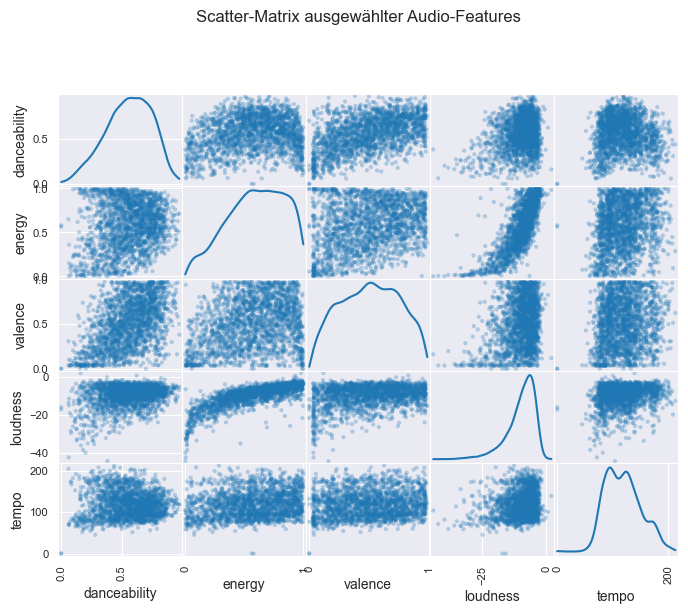

In [79]:
from pandas.plotting import scatter_matrix

selected_cols = [c for c in ["danceability", "energy", "valence", "loudness", "tempo"] if c in audio.columns]
if len(selected_cols) >= 3:
    plt.figure(figsize=(8, 6))
    scatter_matrix(audio[selected_cols].sample(2000, random_state=42), figsize=(8, 6), alpha=0.3, diagonal="kde")
    plt.suptitle("Scatter-Matrix ausgewählter Audio-Features", y=1.02, fontsize=12)
    plt.show()


## Analyse der Scatter-Matrix ausgewählter Audio-Features

### Verteilungen (Diagonale)

* **danceability**: unimodal, Schwerpunkt im mittleren bis höheren Bereich (ca. 0,5–0,7). Die meisten Tracks sind moderat gut tanzbar.
* **energy**: deutlich zu höheren Werten verschoben (ca. 0,6–0,9). Im Datensatz gibt es viele „energetische“ Tracks.
* **valence**: relativ breit verteilt, Häufung im mittleren Bereich (ca. 0,4–0,7). Es gibt keine starke Trennung in „sehr traurig“ vs. „sehr happy“.
* **loudness**: starker Peak bei typischen, modern gemasterten Lautheitswerten (ca. -10 bis -5 dB) und ein Ausläufer zu leiseren Tracks.
* **tempo**: wirkt multimodal (mehrere „Hügel“), was zu typischen BPM-Clusterungen in Musik passt.

### Starke Beziehung (außerhalb der Diagonale)

* **energy vs. loudness**: klar positive und sichtbar nicht-lineare Beziehung. Mit steigender Energy steigt typischerweise auch die Loudness (wird weniger negativ in dB).
  Interpretation: beide Features sind teilweise redundant und können stark korreliert bzw. kollinear sein.

### Schwache oder kaum erkennbare Beziehungen

* **tempo vs. andere Features**: kaum eine klare Beziehung zu Danceability, Energy, Valence oder Loudness. Die Punktwolken zeigen keine deutliche Struktur oder Steigung.
* **danceability vs. valence**: höchstens eine schwache positive Tendenz (fröhlichere Tracks evtl. etwas tanzbarer), aber nicht stark.
* **danceability vs. energy**: überwiegend diffuse Punktwolke, nur geringe Struktur.
* **valence vs. energy**: ebenfalls schwach; hohe Energy tritt über ein breites Valence-Spektrum auf.

### Implikationen fürs Modellieren

* **Multikollinearität**: Energy und Loudness hängen stark zusammen.

  * Für lineare Modelle: Regularisierung (Ridge/Lasso) nutzen oder eines der beiden Features weglassen.
  * Für baumbasierte Modelle: meist unkritisch, aber Feature-Importance kann sich auf beide verteilen.
* **Tempo**: als linearer Prädiktor vermutlich schwächer, kann aber in nicht-linearen Modellen oder über Interaktionen trotzdem hilfreich sein.
* **Insgesamt**: abgesehen von Energy–Loudness wirken die meisten paarweisen Zusammenhänge eher schwach. Reine Korrelation als Feature-Selektion kann daher komplexere Muster übersehen.


### 1.6 Missing Values & Data Completeness

**Ziel**
Ich ermittle die Datenvollständigkeit je Tabelle:
- Anteil fehlender Werte (`NaN`) pro Spalte
- Heatmap der Missing-Pattern
- Export als CSV je Tabelle

**Ergebnis**
- `missing_<table>.csv` pro Tabelle
- `missing_heatmap_<table>.png` (optional)
- Interpretation: Wo fehlen Daten signifikant?



=== TRACKS ===


missing_pct
is_playable             99.27
preview_url             28.16
name                     0.03
audio_feature_id         0.00
disc_number              0.00
track_id                 0.00
duration                 0.00
explicit                 0.00
track_number             0.00
popularity               0.00

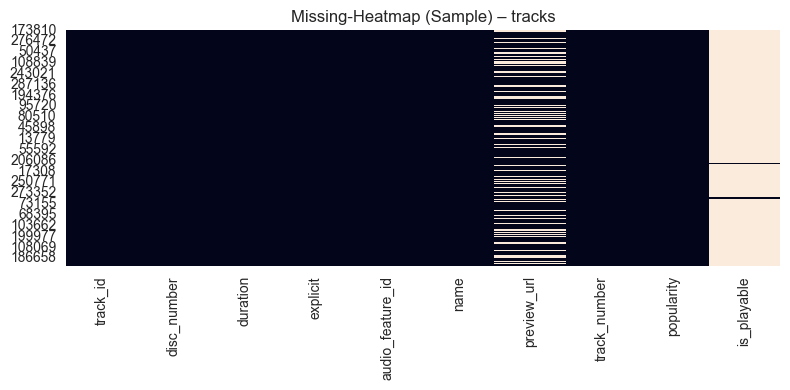


=== AUDIO_FEATURES ===


missing_pct
id                        0.0
acousticness              0.0
analysis_url              0.0
danceability              0.0
duration                  0.0
energy                    0.0
instrumentalness          0.0
key                       0.0
liveness                  0.0
loudness                  0.0
mode                      0.0
speechiness               0.0
tempo                     0.0
time_signature            0.0
valence                   0.0

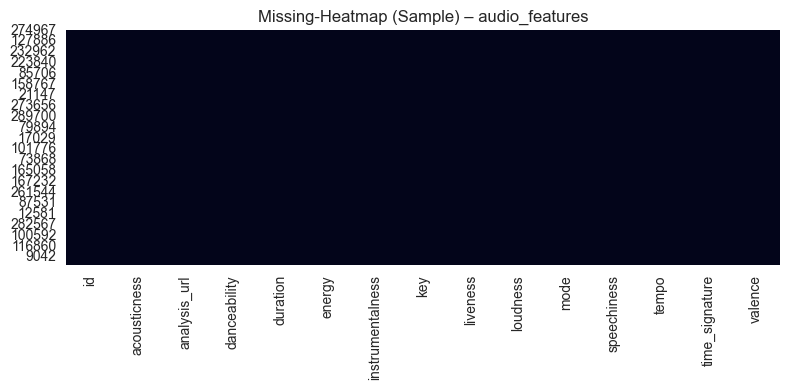


=== ARTISTS ===


missing_pct
name                0.0
id                  0.0
popularity          0.0
followers           0.0

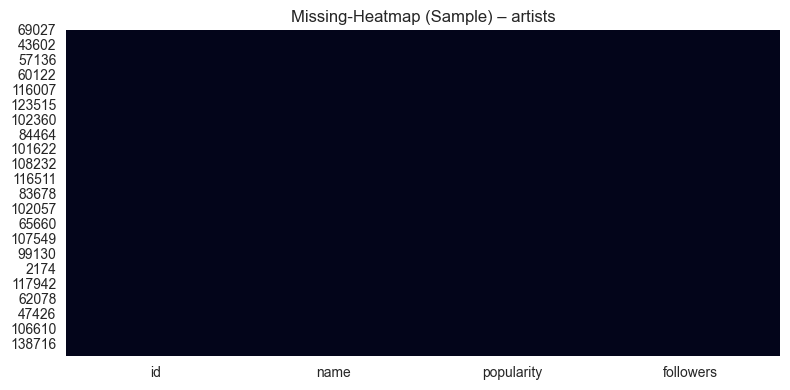


=== ALBUMS ===


missing_pct
album_group        100.00
name                 0.02
id                   0.00
album_type           0.00
release_date         0.00
popularity           0.00

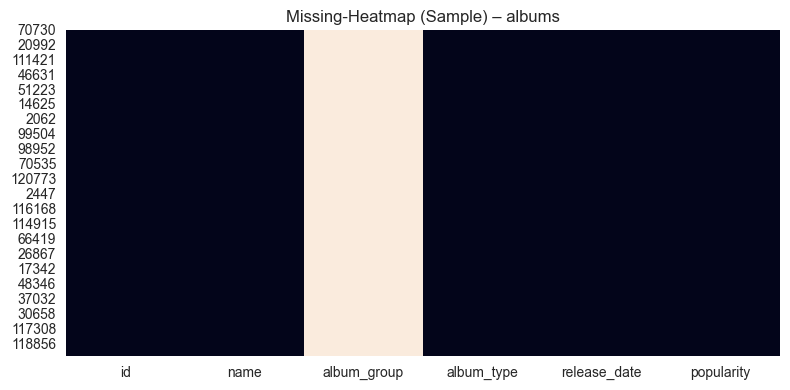

 Missing-Reports gespeichert unter: C:\GitHub\data-science\uni-course\spotify-data-project\data\reports\01_schema_overview\missing


In [80]:
from pathlib import Path
from datetime import datetime

DATA_DIR = Path("../data/interim/converted_sqlite")
RUN_TS = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
REPORT_DIR = Path(f"../data/reports/01_schema_overview/missing")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

tables = {}
for name, fname in [
    ("tracks", "tracks.csv"),
    ("audio_features", "audio_features.csv"),
    ("artists", "artists.csv"),
    ("albums", "albums.csv"),
]:
    p = DATA_DIR / fname
    if p.exists():
        tables[name] = pd.read_csv(p)


def missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    ms = (df.isna().mean() * 100).sort_values(ascending=False).round(2)
    return ms.to_frame("missing_pct")


for name, df in tables.items():
    print(f"\n=== {name.upper()} ===")
    ms = missing_summary(df)
    display(ms.head(20))
    ms.to_csv(REPORT_DIR / f"missing_{name}.csv", encoding="utf-8")
    # Heatmap (nur bei breiten Tabellen sinnvoll)
    plt.figure(figsize=(8, 4))
    sns.heatmap(df.sample(min(len(df), 1000), random_state=42).isna(), cbar=False)
    plt.title(f"Missing-Heatmap (Sample) – {name}")
    plt.tight_layout()
    plt.savefig(REPORT_DIR / f"missing_heatmap_{name}.png", dpi=150)
    plt.show()

print(f" Missing-Reports gespeichert unter: {REPORT_DIR.resolve()}")


#### Fehlende Werte – Zusammenfassung

Die Überprüfung der fehlenden Werte zeigt, dass **nur die Tabellen `tracks` und `albums`** relevante Lücken enthalten.
Alle anderen Datensätze (Artists, Audio-Features, Genres, Verknüpfungstabellen) sind **vollständig** und weisen **keine fehlenden Werte** auf.

---

####  Tracks
- **is_playable (95.23 %)** – größtenteils leer; betrifft Songs, die vermutlich aufgrund von Lizenz- oder Regionsbeschränkungen nicht verfügbar sind.
- **preview_url (26.11 %)** – rund ein Viertel der Songs ohne Hörprobe.
- **name (0.04 %)**, **audio_feature_id (0.01 %)** – minimale Ausfälle, praktisch irrelevant.
- Alle anderen Spalten (`duration`, `explicit`, `track_number`, `popularity` u. a.) sind vollständig.

 **Bewertung:**
Die `tracks`-Tabelle ist insgesamt solide, enthält aber signifikante Lücken bei `is_playable` und `preview_url`. Diese Felder sollten bei späteren Analysen **bewusst behandelt oder ausgeschlossen** werden.

---

####  Albums
- **album_group (100 %)** – komplett leer, keine nutzbaren Informationen.
- **name (0.09 %)** – vereinzelte fehlende Werte.
- Alle übrigen Felder (`album_type`, `release_date`, `popularity`, `id`) sind vollständig.

 **Bewertung:**
Die `albums`-Tabelle weist nur ein inhaltlich bedeutungsloses Feld (`album_group`) auf. Ansonsten ist die Datenqualität **sehr hoch**.

---


### 1.7 Eindeutigkeit, Duplikate & Fremdschlüssel-Integrität

**Ziel**
Ich prüfe die Datenintegrität:
- Eindeutigkeit der Primärschlüssel (z. B. `id`)
- Duplikate pro Tabelle
- Fremdschlüssel-Konsistenz (z. B. `r_track_artist.track_id` existiert in `tracks.id`)

**Ergebnis**
- `integrity_report.csv` mit Kennzahlen
- ggf. Listen der verletzten Referenzen


In [81]:
import pandas as pd
from pathlib import Path

# 1) Pfade – passe bei Bedarf an (hier: schneller konsistenter Export)
DATA_DIR = Path("../data/interim/converted_sqlite")   # oder ../data/interim/sqlite_consistent
INTEG_DIR = Path(f"../data/reports/01_schema_overview/integrity")
INTEG_DIR.mkdir(parents=True, exist_ok=True)

def load(name):
    p = DATA_DIR / f"{name}.csv"
    return pd.read_csv(p) if p.exists() else None

# 2) Laden
tracks = load("tracks")
audio   = load("audio_features")
artists = load("artists")
albums  = load("albums")
rta     = load("r_track_artist")
rat     = load("r_albums_tracks")
rag     = load("r_artist_genre")
genres  = load("genres")

# 3) Utils
def key_col_for(table_name: str) -> str:
    # in deinem Export hat nur tracks die Spalte "track_id", alle anderen "id"
    return "track_id" if table_name == "tracks" else "id"

def pct(part, whole):
    return 0.0 if whole == 0 else round(100.0 * part / whole, 3)

rows = []

def report_row(table, check, status, n_bad, n_total):
    rows.append({
        "table": table,
        "check": check,
        "status": status,
        "n_bad": int(n_bad) if n_bad is not None else None,
        "n_total": int(n_total) if n_total is not None else None,
        "pct_bad": pct(n_bad, n_total) if (n_bad is not None and n_total) else None
    })

# 4) Duplikate + (optional) ID-Eindeutigkeit pro Tabelle
def check_table(table_name: str, df: pd.DataFrame):
    if df is None:
        report_row(table_name, "duplicates_all_cols", "skip", None, None)
        report_row(table_name, f"unique({key_col_for(table_name)})", "skip", None, None)
        return
    # Duplikate über alle Spalten
    dups = df.duplicated().sum()
    report_row(table_name, "duplicates_all_cols", "ok" if dups == 0 else "warn", dups, len(df))

    # ID-Eindeutigkeit wenn Key existiert
    key = key_col_for(table_name)
    if key in df.columns:
        dup_ids = df[key].duplicated().sum()
        report_row(table_name, f"unique({key})", "ok" if dup_ids == 0 else "warn", dup_ids, len(df))
    else:
        report_row(table_name, f"unique({key})", "skip", None, None)

for name, df in [("tracks", tracks), ("audio_features", audio), ("artists", artists), ("albums", albums),("genres", genres),]:
    check_table(name, df)

# 5) Fremdschlüssel-Checks (Schema-bewusst)
def fk_check(child_df, child_key, parent_df, parent_key, table_label):
    if child_df is None or parent_df is None or child_key not in child_df.columns or parent_key not in parent_df.columns:
        report_row(table_label, f"fk({child_key}->{table_label.split(':')[-1]})", "skip", None, None)
        return
    total = len(child_df)
    missing = (~child_df[child_key].isin(parent_df[parent_key])).sum()
    report_row(table_label, f"fk({child_key}->{parent_key})", "ok" if missing == 0 else "warn", missing, total)

# r_track_artist: track_id -> tracks.track_id ; artist_id -> artists.id
if rta is not None:
    fk_check(rta, "track_id", tracks, key_col_for("tracks"), "r_track_artist:tracks")
    fk_check(rta, "artist_id", artists, key_col_for("artists"), "r_track_artist:artists")

# r_albums_tracks: track_id -> tracks.track_id ; album_id -> albums.id
if rat is not None:
    fk_check(rat, "track_id", tracks, key_col_for("tracks"), "r_albums_tracks:tracks")
    fk_check(rat, "album_id", albums, key_col_for("albums"), "r_albums_tracks:albums")

# tracks.audio_feature_id -> audio_features.id
if tracks is not None and audio is not None and "audio_feature_id" in tracks.columns and "id" in audio.columns:
    total = tracks["audio_feature_id"].notna().sum()
    missing = (~tracks.loc[tracks["audio_feature_id"].notna(), "audio_feature_id"].isin(audio["id"])).sum()
    report_row("tracks", "fk(audio_feature_id->audio_features.id)", "ok" if missing == 0 else "warn", missing, total)
else:
    report_row("tracks", "fk(audio_feature_id->audio_features.id)", "skip", None, None)


fk_check(rag, "artist_id", artists, key_col_for("artists"), "r_artist_genre:artists")

fk_check(rag, "genre_id", genres, key_col_for("genres"), "r_artist_genre:genres")


# 6) Ausgabe
integ = pd.DataFrame(rows).sort_values(["table","check"]).reset_index(drop=True)
display(integ)

# Save
out_csv = INTEG_DIR / "integrity_report.csv"
integ.to_csv(out_csv, index=False, encoding="utf-8")
print(" Integrity-Report gespeichert unter:", out_csv.resolve())


table                                    check status  \
0                   albums                      duplicates_all_cols     ok   
1                   albums                               unique(id)     ok   
2                  artists                      duplicates_all_cols     ok   
3                  artists                               unique(id)     ok   
4           audio_features                      duplicates_all_cols     ok   
5           audio_features                               unique(id)     ok   
6                   genres                      duplicates_all_cols     ok   
7                   genres                               unique(id)     ok   
8   r_albums_tracks:albums                         fk(album_id->id)     ok   
9   r_albums_tracks:tracks                   fk(track_id->track_id)     ok   
10  r_artist_genre:artists                        fk(artist_id->id)     ok   
11   r_artist_genre:genres                         fk(genre_id->id)     ok   
12  r_track_artist:artists                        fk(artist_id->id)     ok   
13   r_track_artist:tracks                   fk(track_id->track_id)     ok   
14                  tracks                      duplicates_all_cols     ok   
15                  tracks  fk(audio_feature_id->audio_features.id)     ok   
16                  tracks                         unique(track_id)     ok   

    n_bad  n_total  pct_bad  
0       0   129448      0.0  
1       0   129448      0.0  
2       0   139706      0.0  
3       0   139706      0.0  
4       0   294668      0.0  
5       0   294668      0.0  
6       0     5418      0.0  
7       0     5418      0.0  
8       0   306258      0.0  
9       0   306258      0.0  
10      0   169674      0.0  
11      0   169674      0.0  
12      0   391939      0.0  
13      0   391939      0.0  
14      0   294693      0.0  
15      0   294691      0.0  
16      0   294693      0.0

 Integrity-Report gespeichert unter: C:\GitHub\data-science\uni-course\spotify-data-project\data\reports\01_schema_overview\integrity\integrity_report.csv


### 1.8 Feature-Verteilungen nach Kategorien (Genre/Albumtyp)

**Ziel**
Ich vergleiche Audio-Merkmale (z. B. `energy`, `valence`, `tempo`) über **Kategorien** hinweg:
- Standard: `album_type` (z. B. album/single/compilation)
- Optional: `genre` (falls `genres` + `r_artist_genre` vorliegen)


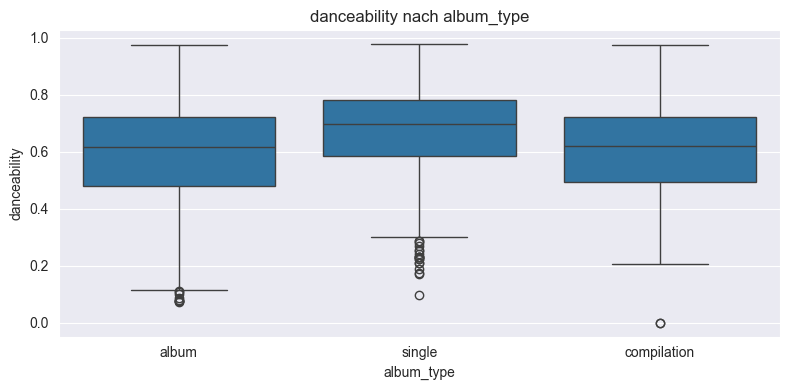

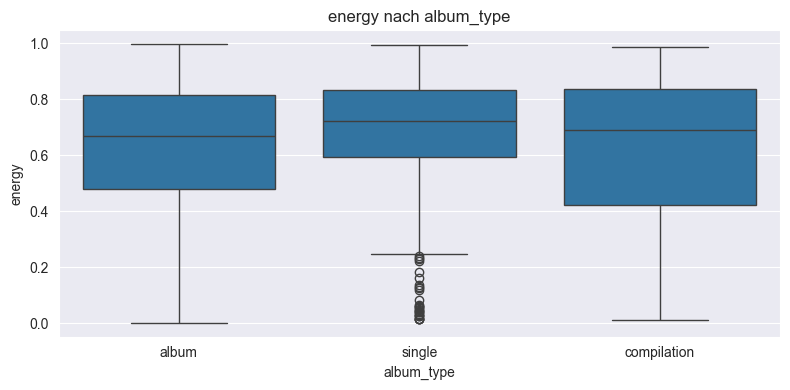

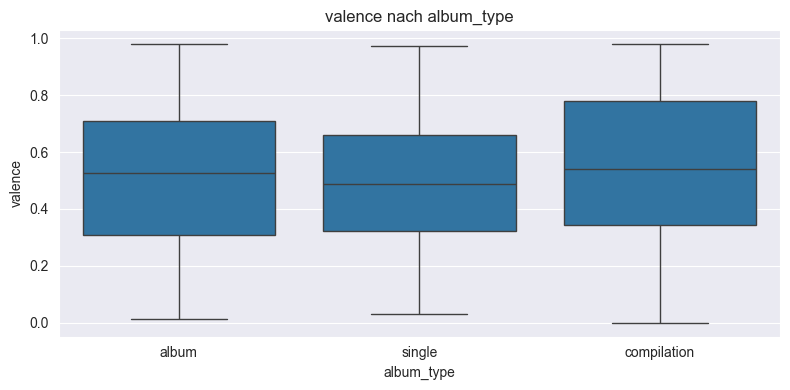

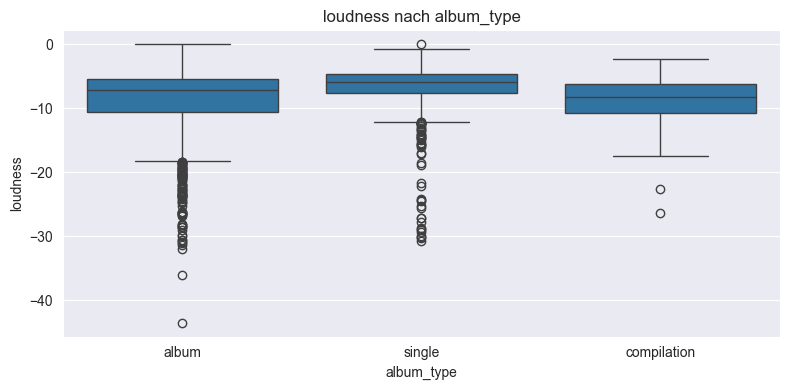

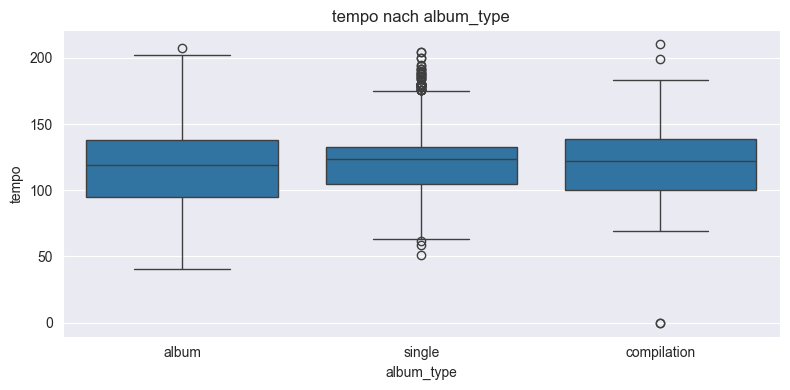

danceability                    energy                    valence  \
                    mean   std median count   mean   std median count    mean   
album_type                                                                      
album               0.59  0.18   0.62  1388   0.62  0.24   0.67  1388    0.51   
compilation         0.60  0.18   0.62   137   0.62  0.25   0.69   137    0.54   
single              0.67  0.15   0.70  1072   0.70  0.19   0.72  1072    0.49   

                               loudness                      tempo         \
              std median count     mean   std median count    mean    std   
album_type                                                                  
album        0.26   0.52  1388    -8.71  5.16  -7.22  1388  118.13  29.04   
compilation  0.27   0.54   137    -8.84  3.86  -8.26   137  119.36  31.87   
single       0.22   0.49  1072    -6.71  3.69  -5.93  1072  122.79  25.52   

                           
             median count  
album_type                 
album        118.80  1388  
compilation  122.07   137  
single       123.80  1072

💾 Kategorien-Auswertung gespeichert unter: C:\GitHub\data-science\uni-course\spotify-data-project\data\reports\01_schema_overview\categories


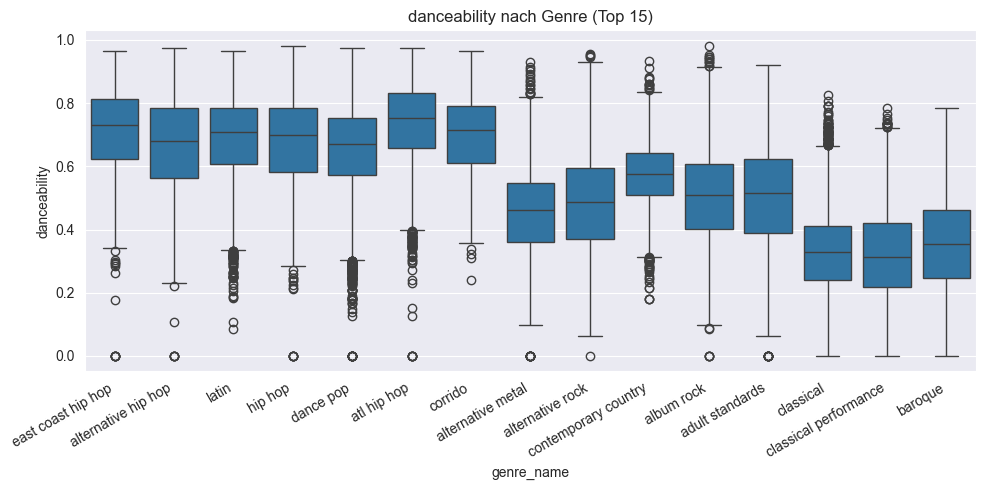

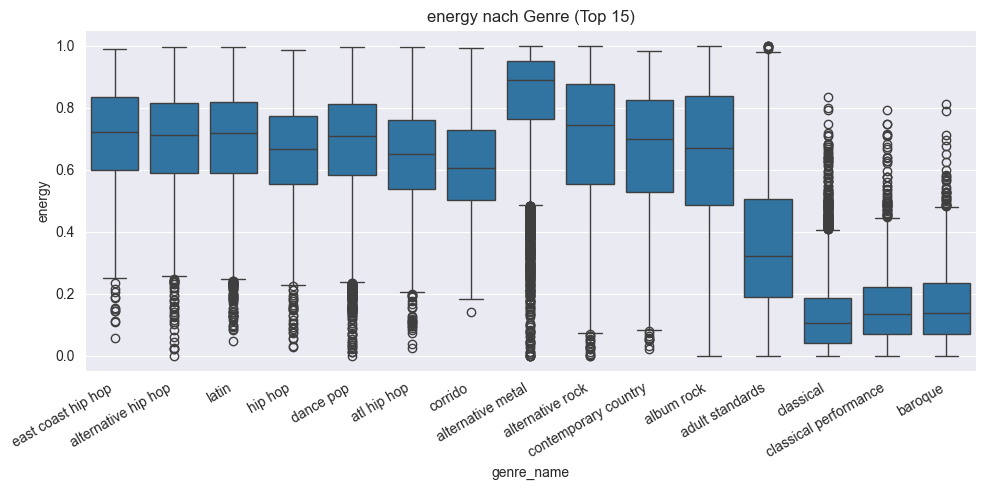

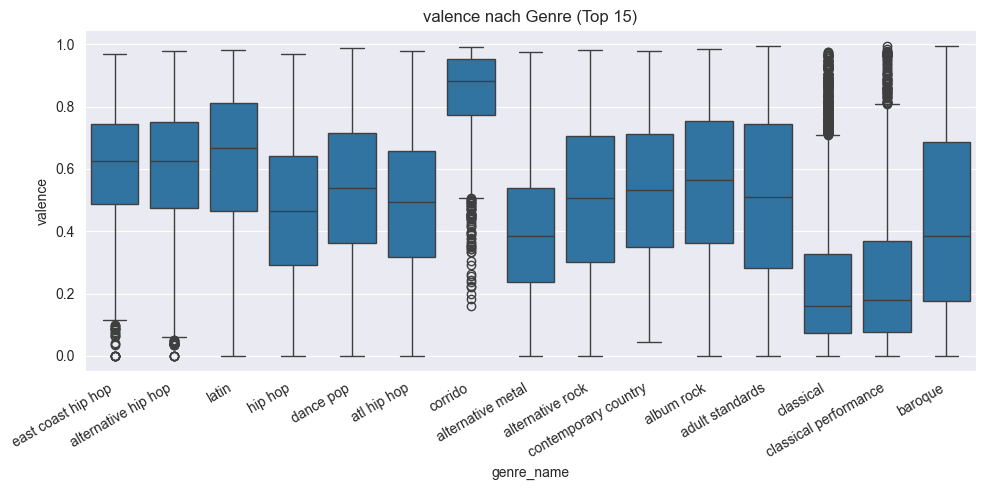

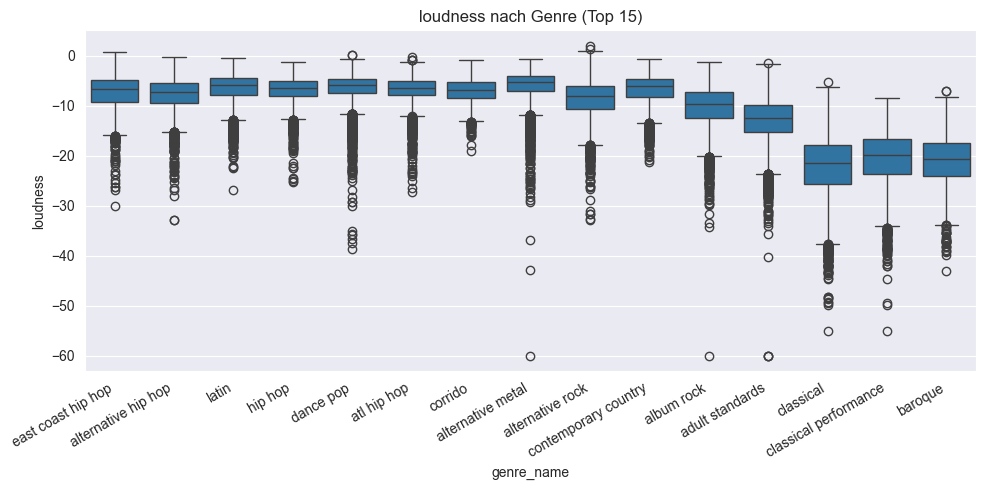

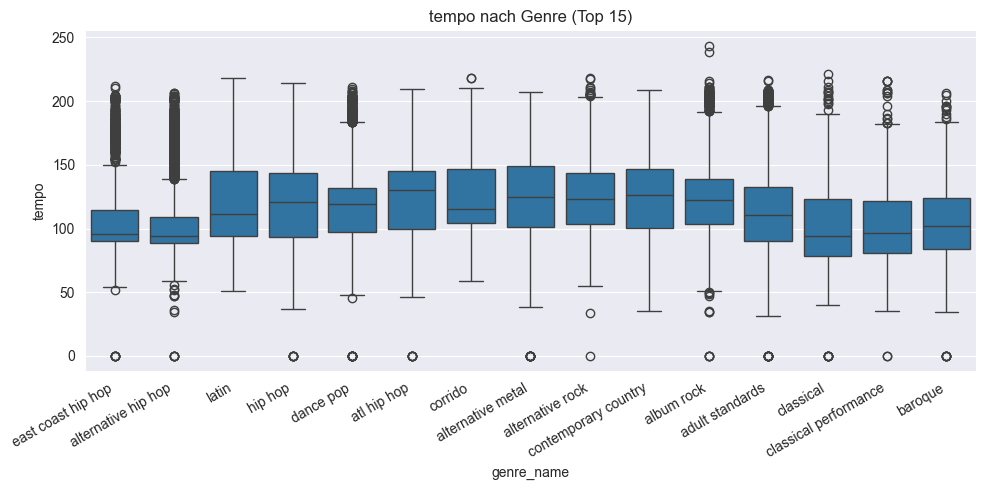

In [82]:
CAT_DIR = Path(f"../data/reports/01_schema_overview/categories")
CAT_DIR.mkdir(parents=True, exist_ok=True)

# Basisdaten
tracks = pd.read_csv(DATA_DIR / "tracks.csv")
audio = pd.read_csv(DATA_DIR / "audio_features.csv")
albums = pd.read_csv(DATA_DIR / "albums.csv")

# Merge: tracks + audio + albums (für album_type + release_date)
tracks = tracks.rename(columns={"id": "track_id"})
audio = audio.rename(columns={"id": "audio_feature_id"})
df = tracks.merge(audio, left_on="audio_feature_id", right_on="audio_feature_id", how="left")
df = df.merge(albums[["id", "album_type", "release_date"]].rename(columns={"id": "album_id"}), how="left",
              left_on="track_id", right_on="album_id")

# Saubere Kategorien
cat_col = "album_type"
num_cols = [c for c in ["danceability", "energy", "valence", "loudness", "tempo"] if c in df.columns]

for y in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=cat_col, y=y)
    plt.title(f"{y} nach {cat_col}")
    plt.tight_layout()
    plt.savefig(CAT_DIR / f"box_{y}_by_{cat_col}.png", dpi=150)
    plt.show()

# Gruppierte Statistiken
group_stats = (
    df.groupby(cat_col)[num_cols]
    .agg(["mean", "std", "median", "count"])
    .round(2)
)
display(group_stats.head(10))
group_stats.to_csv(CAT_DIR / f"stats_{cat_col}.csv", encoding="utf-8")
print(f"💾 Kategorien-Auswertung gespeichert unter: {CAT_DIR.resolve()}")

# Optional: nach Genre (nur wenn verfügbar)
genres_path = DATA_DIR / "genres.csv"
rag_path = DATA_DIR / "r_artist_genre.csv"
rta_path = DATA_DIR / "r_track_artist.csv"
artists_path = DATA_DIR / "artists.csv"

if genres_path.exists() and rag_path.exists() and rta_path.exists() and artists_path.exists():
    genres = pd.read_csv(genres_path)
    rag = pd.read_csv(rag_path)
    rta = pd.read_csv(rta_path)
    artists = pd.read_csv(artists_path)
    # Map track -> artist -> genre (First genre per artist)
    first_genre = rag.merge(genres, left_on="genre_id", right_on="id", how="left").dropna(subset=["id"])
    first_genre = first_genre.drop_duplicates(subset=["artist_id"]).rename(columns={"id": "genre_name"})
    track_genre = rta.merge(first_genre[["artist_id", "genre_name"]], on="artist_id", how="left")
    df_g = tracks.merge(track_genre[["track_id", "genre_name"]], on="track_id", how="left").merge(audio,
                                                                                                  on="audio_feature_id",
                                                                                                  how="left")
    # Top 15 Genres
    top_genres = df_g["genre_name"].value_counts().head(15).index
    df_g = df_g[df_g["genre_name"].isin(top_genres)]
    for y in num_cols:
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=df_g, x="genre_name", y=y)
        plt.title(f"{y} nach Genre (Top 15)")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.savefig(CAT_DIR / f"box_{y}_by_genre_top15.png", dpi=150)
        plt.show()



### 1.8 Feature-Verteilungen nach Kategorien (Genre / Albumtyp) – Observations

#### A) Unterschiede nach `album_type` (Boxplots + deine Kennzahlen)

* **Singles sind im Schnitt „tanzbarer“ und „energetischer“ als Alben/Compilations.**
  Deine Tabelle bestätigt das klar:

  * `danceability`: **single 0.67** vs. album 0.59 / compilation 0.60
  * `energy`: **single 0.70** vs. album 0.62 / compilation 0.62
    Das sieht man auch im Boxplot: Median und Verteilung liegen bei *single* höher, bei kleinerer Streuung.
* **Singles sind im Mittel deutlich lauter (weniger negative dB).**

  * `loudness`: **single -6.71** vs. album -8.71 / compilation -8.84
    Der Boxplot zeigt: Singles liegen insgesamt „oben“ (näher an 0 dB), während Alben/Compilations mehr sehr leise Ausreißer haben.
* **Valence ist bei Singles leicht niedriger als bei Album/Compilation.**

  * `valence`: single **0.49** vs. album 0.51 / compilation 0.54
    Interpretation: Singles wirken im Datensatz im Schnitt zwar energetischer/lauter, aber nicht zwingend „positiver“.
* **Tempo ist bei Singles etwas höher, aber der Effekt ist klein.**

  * `tempo`: single **122.79** vs. album 118.13 / compilation 119.36
    Boxplot: starke Überlappung, Unterschied eher subtil.
* **Stichprobengrößen sind ungleich:** album (n=1388) >> single (n=1072) >> compilation (n=137).
  Heißt: Aussagen zu *compilation* sind statistisch weniger stabil.

#### B) Unterschiede nach `genre` (Top 15)

* **Danceability trennt Genres am deutlichsten.**

  * Höhere Danceability bei (Sub-)Hip-Hop/Latin-nahen Genres (z. B. *east coast hip hop*, *atl hip hop*, *latin*).
  * Niedrigere Danceability bei klassischen Genres (*classical*, *classical performance*, *baroque*) – die Boxen liegen sichtbar tiefer.
* **Energy unterscheidet Genres sehr klar.**

  * Sehr hohe Energy bei rock-/metal-nahen Genres (z. B. *alternative metal*, *alternative rock*).
  * Sehr niedrige Energy bei *classical* / *classical performance* / *baroque*.
  * *adult standards* liegt typischerweise im mittleren bis niedrigeren Energiebereich.
* **Loudness folgt dem gleichen Muster wie Energy (sehr konsistent).**

  * Pop/Hip-Hop/Latin/Rock sind deutlich lauter (typisch um ca. -10 bis -5 dB).
  * Klassische Genres sind deutlich leiser (Boxen eher um ca. -25 bis -15 dB).
    Das ist wichtig, weil es zeigt: **Genre → Produktions-/Mastering-Stil** spiegelt sich stark in den Audio-Features wider.
* **Tempo unterscheidet Genres weniger stark als Energy/Danceability.**

  * Viele Genres überlappen stark (typisch 90–140 BPM).
  * Hip-Hop wirkt tendenziell niedriger im Median (um ~90–110), andere Genres eher um ~110–130, aber die Streuung ist groß.
* **Valence zeigt genretypische Tendenzen, aber mit viel Überlappung.**

  * Klassische Genres haben im Median oft niedrigere Valence (Boxen tief), gleichzeitig sieht man teils viele höhere Ausreißer → kann auf gemischte Zuordnung, Crossover oder Genre-Mapping-Effekte hindeuten.
  * *corrido* fällt als stark „hohe Valence“-Cluster auf (Box sehr weit oben).

#### C) Datenqualität / Plausibilitätschecks (aus den Ausreißern sichtbar)

* **Tempo-Ausreißer bei 0** (z. B. bei compilation) wirken wie Mess-/Parsingfehler oder fehlende Werte, die als 0 gelandet sind. Das solltest du in Cleaning-Regeln abfangen (z. B. `tempo <= 0` → NaN oder Drop).
* **Extrem leise Loudness bis ~-60 dB** sind auffällig. Das können echte sehr leise Aufnahmen sein, oft aber auch „Stille“, Intros, oder fehlerhafte Tracks. Hier lohnt sich ein Regelcheck (z. B. Quantile/Winsorizing oder Flagging).
* **Danceability/Valence nahe 0** treten als Ausreißer auf – nicht automatisch falsch, aber gut zum Prüfen auf Anomalien.

#### D) Implikation für dein ML-Setup

* `album_type` und `genre` enthalten **relevante Struktur**, weil sie systematische Unterschiede in den Features erklären (besonders Energy/Loudness/Danceability).
  Das ist gut für Modelle, aber du solltest aufpassen:

  * Wenn `genre` über Artist-Mapping kommt (Many-to-Many), kann es **mehrdeutig** sein (ein Track erbt mehrere Genres). Dann brauchst du eine klare Strategie (z. B. Top-Genre, Multi-Hot-Encoding, oder Aggregation).
* Da **Energy und Loudness** je Genre/Albumtyp gemeinsam „wandern“, sind sie inhaltlich teilweise redundant. Bei linearen Modellen ist Regularisierung sinnvoll.


### 1.9 Zeitliche Trends (Release-Jahre)

**Ziel**
Ich analysiere die Entwicklung musikalischer Merkmale über die Zeit (pro Jahr):
- Jahresdurchschnitt von `tempo`, `energy`, `valence`, `loudness`
- Gleitender Durchschnitt (k=3) zur Glättung

**Ergebnis**
- `yearly_trends.csv`
- Trendplots als PNG


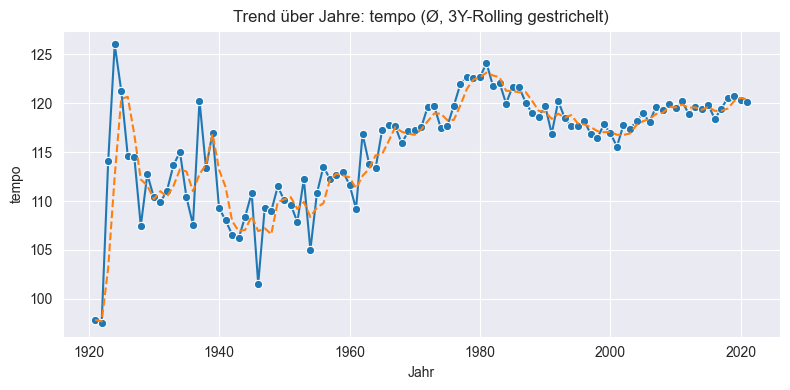

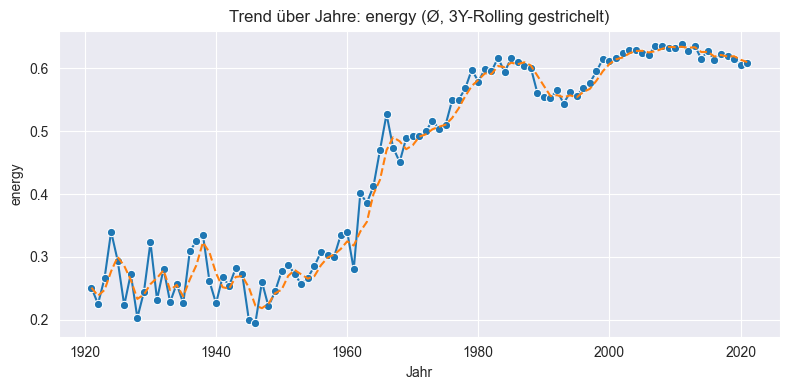

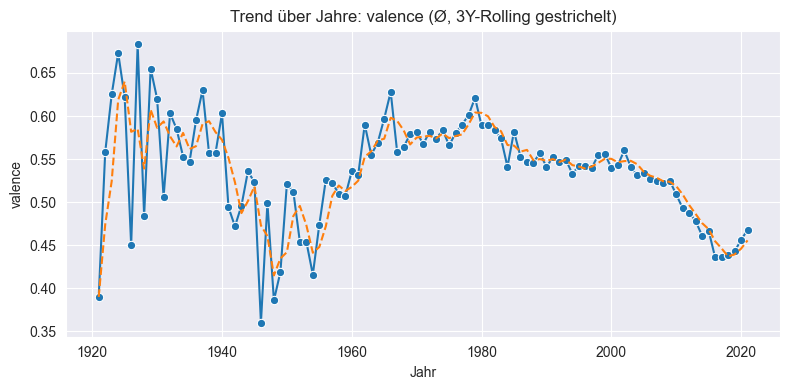

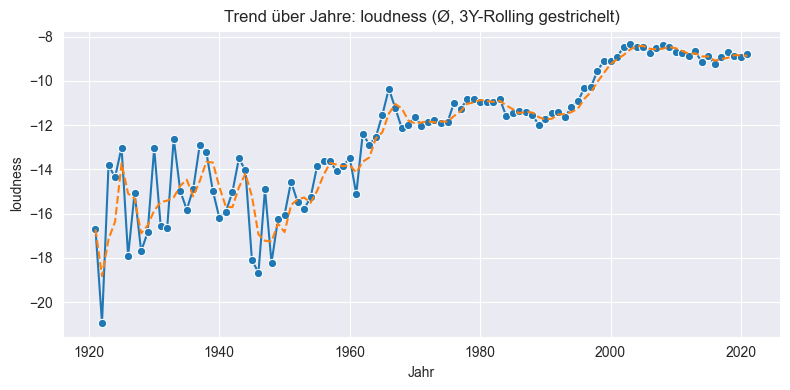

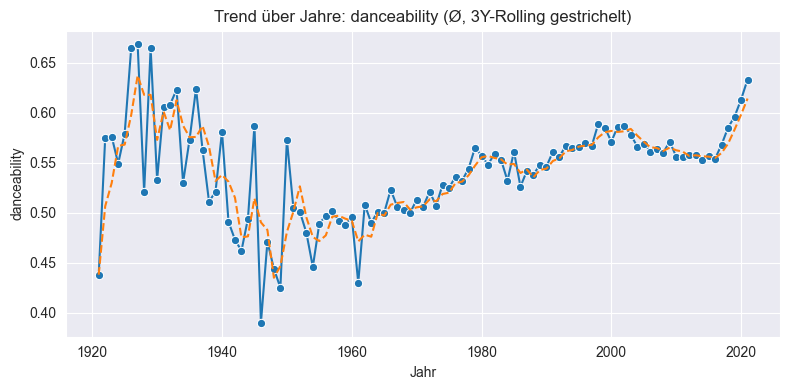

 Trend-Reports gespeichert unter: C:\GitHub\data-science\uni-course\spotify-data-project\data\reports\01_schema_overview\trends


In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

TREND_DIR = Path("../data/reports/01_schema_overview/trends")
TREND_DIR.mkdir(parents=True, exist_ok=True)

# Load
tracks = pd.read_csv(DATA_DIR / "tracks.csv").rename(columns={"id": "track_id"})
audio  = pd.read_csv(DATA_DIR / "audio_features.csv").rename(columns={"id": "audio_feature_id"})
albums = pd.read_csv(DATA_DIR / "albums.csv")[["id", "release_date"]].rename(columns={"id": "album_id"})

# Optional relation (best way to map tracks -> albums)
rat_path = DATA_DIR / "r_albums_tracks.csv"
r_at = pd.read_csv(rat_path) if rat_path.exists() else None

# Base merge (tracks + audio)
df = tracks.merge(audio, on="audio_feature_id", how="left")

# Attach album_id properly
if r_at is not None:
    df = df.merge(r_at[["track_id", "album_id"]], on="track_id", how="left")
elif "album_id" in tracks.columns:
    df = df.merge(tracks[["track_id", "album_id"]], on="track_id", how="left")
else:
    df["album_id"] = pd.NA

# Join albums to get release_date
df = df.merge(albums, on="album_id", how="left")

# Parse release_date: it's ms timestamps (per your sample)
# (works whether dtype is str, int, or float)
s = pd.to_numeric(df["release_date"], errors="coerce")
df["release_dt"] = pd.to_datetime(s, unit="ms", errors="coerce")
df["year"] = df["release_dt"].dt.year

# Features & yearly aggregation
feat_cols = [c for c in ["tempo", "energy", "valence", "loudness", "danceability"] if c in df.columns]
yearly = (
    df.dropna(subset=["year"])
      .groupby("year")[feat_cols]
      .mean()
      .round(3)
)

# Add counts to judge stability; optionally filter sparse years
yearly["count"] = df.groupby("year")["track_id"].count()
MIN_YEAR_COUNT = 50
yearly_filtered = yearly[yearly["count"] >= MIN_YEAR_COUNT]

# Save table
yearly_filtered.to_csv(TREND_DIR / "yearly_trends.csv", encoding="utf-8", index=True)

# Plots: per-feature trend + 3Y rolling mean (dashed)
for c in feat_cols:
    s = yearly_filtered[c].dropna()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=s.index, y=s.values, marker="o")
    if len(s) >= 3:
        s_roll = s.rolling(3, min_periods=1).mean()
        sns.lineplot(x=s_roll.index, y=s_roll.values, linestyle="--")
    plt.title(f"Trend über Jahre: {c} (Ø, 3Y-Rolling gestrichelt)")
    plt.xlabel("Jahr"); plt.ylabel(c)
    plt.tight_layout()
    plt.savefig(TREND_DIR / f"trend_{c}.png", dpi=150)
    plt.show()

print(f" Trend-Reports gespeichert unter: {TREND_DIR.resolve()}")



## 1.10 Cross-Table Relationship: Artist Influence

**Ziel**
Ich untersuche, ob **Künstler-Reichweite** (Followers) mit **Erfolg ihrer Songs** (Ø-Track-Popularität) zusammenhängt.

**Ergebnis**
- Scatter + Regressionslinie (log-Followers)
- `artist_influence.csv`


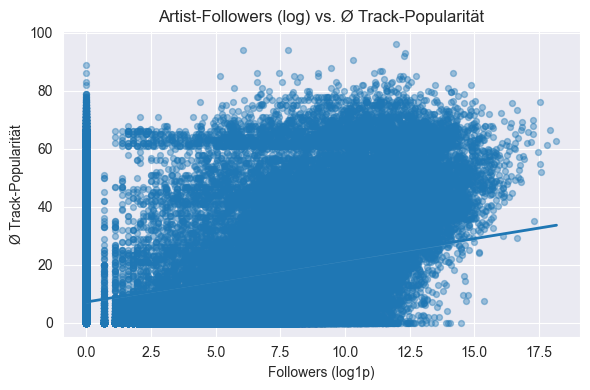

 Artist-Influence gespeichert unter: C:\GitHub\data-science\uni-course\spotify-data-project\data\reports\01_schema_overview\influence
Columns used: {'tracks': ['track_id', 'track_popularity'], 'artists': ['artist_id', 'followers', 'artist_popularity'], 'r_track_artist': ['track_id', 'artist_id']}


In [84]:
INF_DIR = Path("../data/reports/01_schema_overview/influence")
INF_DIR.mkdir(parents=True, exist_ok=True)

# --- Helpers to resolve column names across schema variants
def pick(dframe, candidates, required=True):
    for c in candidates:
        if c in dframe.columns:
            return c
    if required:
        raise KeyError(f"None of {candidates} found in columns: {list(dframe.columns)}")
    return None

# --- Load CSVs
tracks = pd.read_csv(DATA_DIR / "tracks.csv", encoding="utf-8")  # ensure headers load
artists = pd.read_csv(DATA_DIR / "artists.csv", encoding="utf-8")
rta = pd.read_csv(DATA_DIR / "r_track_artist.csv", encoding="utf-8")

# --- Resolve column names
track_id_col = pick(tracks, ["track_id", "id"])
track_pop_col = pick(tracks, ["popularity"])

artist_id_col = pick(artists, ["artist_id", "id"])
followers_col  = pick(artists, ["followers", "followers_count"])
artist_pop_col = pick(artists, ["artist_popularity", "popularity"], required=False)  # optional

rta_track_col  = pick(rta, ["track_id", "trackId", "trackID"])
rta_artist_col = pick(rta, ["artist_id", "artistId", "artistID"])

# --- Minimal frames with normalized names
tracks_min = tracks[[track_id_col, track_pop_col]].rename(
    columns={track_id_col: "track_id", track_pop_col: "track_popularity"}
)

artists_min_cols = [artist_id_col, followers_col]
rename_map = {artist_id_col: "artist_id", followers_col: "followers"}
if artist_pop_col:
    artists_min_cols.append(artist_pop_col)
    rename_map[artist_pop_col] = "artist_popularity"

artists_min = artists[artists_min_cols].rename(columns=rename_map)

rta_min = rta[[rta_track_col, rta_artist_col]].rename(
    columns={rta_track_col: "track_id", rta_artist_col: "artist_id"}
)

# --- Avg track popularity per artist
track_pop_by_artist = (
    rta_min.merge(tracks_min, on="track_id", how="left")
           .groupby("artist_id", as_index=False)["track_popularity"]
           .mean()
           .rename(columns={"track_popularity": "avg_track_popularity"})
)

# --- Combine with artist followers (and optional artist_popularity)
df = artists_min.merge(track_pop_by_artist, on="artist_id", how="left")
df = df.dropna(subset=["avg_track_popularity"])

# Followers cleaning: ensure non-negative numbers
df["followers"] = pd.to_numeric(df["followers"], errors="coerce").fillna(0).clip(lower=0)

# Log-transform followers (log1p handles zeros)
df["followers_log1p"] = np.log1p(df["followers"])

# --- Plot: Scatter + regression line
plt.figure(figsize=(6, 4))
sns.regplot(
    data=df,
    x="followers_log1p",
    y="avg_track_popularity",
    scatter_kws={"alpha": 0.4, "s": 18},
    line_kws={"linewidth": 2}
)
plt.title("Artist-Followers (log) vs. Ø Track-Popularität")
plt.xlabel("Followers (log1p)")
plt.ylabel("Ø Track-Popularität")
plt.tight_layout()
plt.savefig(INF_DIR / "artist_followers_vs_avg_track_popularity.png", dpi=150)
plt.show()

# --- Save CSV
cols_out = ["artist_id", "followers", "avg_track_popularity", "followers_log1p"]
if "artist_popularity" in df.columns:
    cols_out.insert(2, "artist_popularity")

df[cols_out].to_csv(INF_DIR / "artist_influence.csv", index=False, encoding="utf-8-sig")

print(f" Artist-Influence gespeichert unter: {INF_DIR.resolve()}")
print("Columns used:",
      {"tracks": list(tracks_min.columns),
       "artists": list(artists_min.columns),
       "r_track_artist": list(rta_min.columns)})

